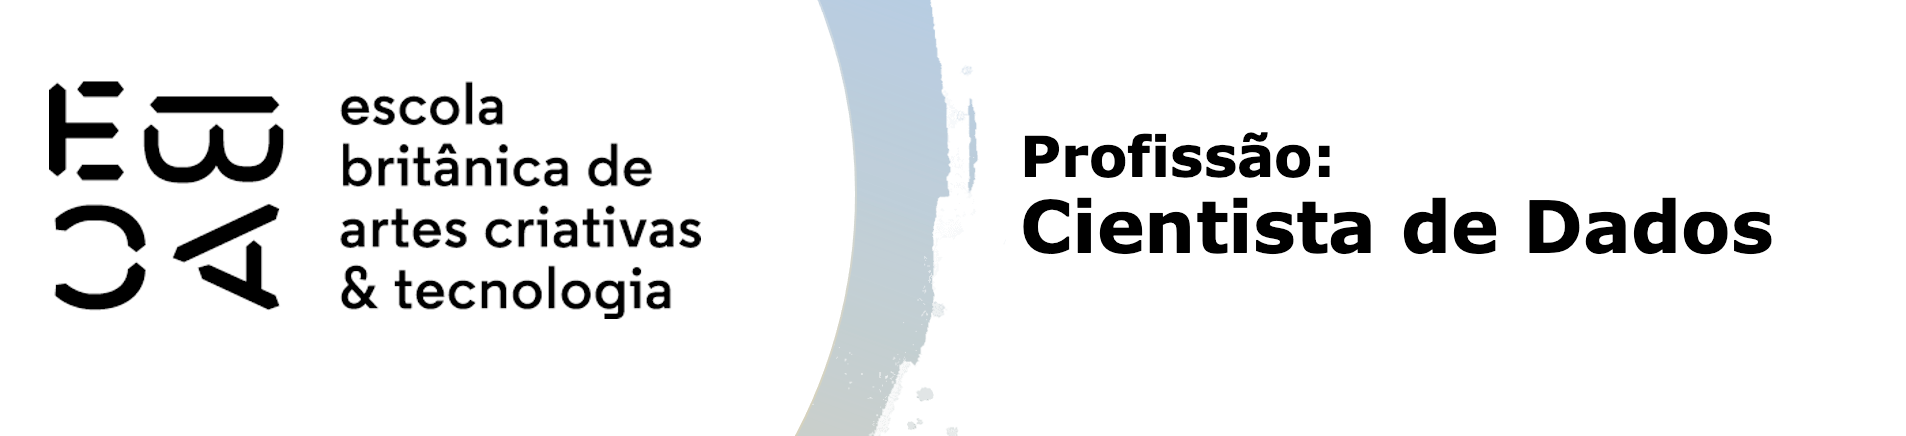

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import sys

def preparar_amostragem_oot(file_path='credit_scoring.ftr'):
    """
    Carrega os dados e separa em bases de Desenvolvimento (DEV) e
    Validação Out-of-Time (OOT) com base nos 3 últimos meses.

    Também separa as bases em X (features) e y (target).
    """
    
    # --- 1. Carregamento dos Dados ---
    print(f"Carregando dados de: {file_path}")
    try:
        # Carrega o arquivo em formato feather
        df = pd.read_feather(file_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo '{file_path}' não encontrado.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    # --- 2. Tratamento da Data de Referência ---
    # Garante que a coluna 'data_ref' é do tipo datetime
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    print("Coluna 'data_ref' convertida para datetime.")

    # --- 3. Identificação da Data de Corte (Split) ---
    
    # Encontra a data mais recente no conjunto de dados
    max_data = df['data_ref'].max()
    if pd.isna(max_data):
        print("Erro: Não foi possível encontrar a data máxima (max_data).", file=sys.stderr)
        return None

    # Calcula o primeiro dia do mês da data mais recente
    # Ex: Se max_data = 2023-05-20, inicio_ultimo_mes = 2023-05-01
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()

    # Define a data de corte para a OOT.
    # Queremos os 3 últimos meses (M, M-1, M-2).
    # Subtraímos 2 meses do início do último mês para encontrar o início do período OOT.
    # Ex: 2023-05-01 - 2 meses = 2023-03-01.
    # OOT = Dados >= 2023-03-01 (Março, Abril, Maio)
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)

    print(f"Data máxima nos dados: {max_data.date()}")
    print(f"Data de corte (início da OOT): {data_corte_oot.date()}")

    # --- 4. Separação das Safras (DEV e OOT) ---
    
    # Base OOT (Out-of-Time): >= data de corte (3 últimos meses)
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    # Base DEV (Desenvolvimento): < data de corte (todos os meses anteriores)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()

    print("\n--- Divisão das Safras ---")
    print(f"Total de registros: {len(df)}")
    if not df_dev.empty:
        print(f"Registros na base de DEV: {len(df_dev)} (Período: {df_dev['data_ref'].min().date()} a {df_dev['data_ref'].max().date()})")
    else:
        print("Registros na base de DEV: 0")
        
    if not df_oot.empty:
        print(f"Registros na base OOT: {len(df_oot)} (Período: {df_oot['data_ref'].min().date()} a {df_oot['data_ref'].max().date()})")
    else:
        print("Registros na base OOT: 0")

    if df_dev.empty or df_oot.empty:
        print("\nAviso: Uma das bases (DEV ou OOT) está vazia. Verifique suas datas.", file=sys.stderr)
        # Pode decidir retornar None ou continuar dependendo da lógica de negócio
        # return None

    # --- 5. Definição de Features (X) e Target (y) ---
    
    # Variável Alvo (dependente)
    target = 'mau'

    # Variáveis que não devem ser usadas como explicativas (covariáveis)
    # Conforme solicitado: data_ref (indicador de safra) e index (ID do cliente)
    variaveis_nao_explicativas = ['data_ref', 'index']

    # Lista de features (covariáveis)
    # São todas as colunas, exceto o target e as não-explicativas
    try:
        features = [col for col in df.columns if col not in [target] + variaveis_nao_explicativas]
    except AttributeError:
        print("Erro: O DataFrame não parece ter colunas.", file=sys.stderr)
        return None

    print(f"\nVariável Target (Alvo): {target}")
    print(f"Variáveis descartadas (Não-Features): {variaveis_nao_explicativas}")
    print(f"Total de Features (Covariáveis): {len(features)}")
    # print(f"Lista de Features: {features}") # Descomente se quiser ver a lista

    # --- 6. Separação final X/y ---
    
    # Base de Desenvolvimento
    X_dev = df_dev[features]
    y_dev = df_dev[target]

    # Base de Validação Out-of-Time
    X_oot = df_oot[features]
    y_oot = df_oot[target]

    print("\n--- Amostragem Concluída ---")
    print(f"Shape X_dev (Features DEV): {X_dev.shape}")
    print(f"Shape y_dev (Target DEV):   {y_dev.shape}")
    print(f"Shape X_oot (Features OOT): {X_oot.shape}")
    print(f"Shape y_oot (Target OOT):   {y_oot.shape}")

    # Retorna os 4 dataframes separados
    return X_dev, y_dev, X_oot, y_oot

# --- Exemplo de como usar a função ---
if __name__ == "__main__":
    # Esta parte só executa se você rodar o script diretamente
    
    # Chama a função
    resultado = preparar_amostragem_oot(file_path='credit_scoring.ftr')

    if resultado:
        X_dev, y_dev, X_oot, y_oot = resultado
        
        print("\nExemplo de dados (primeiras linhas de X_dev):")
        print(X_dev.head())
        
        print("\nExemplo de dados (primeiras linhas de y_oot):")
        print(y_oot.head())

Carregando dados de: credit_scoring.ftr
Coluna 'data_ref' convertida para datetime.
Data máxima nos dados: 2016-03-01
Data de corte (início da OOT): 2016-01-01

--- Divisão das Safras ---
Total de registros: 750000
Registros na base de DEV: 600000 (Período: 2015-01-01 a 2015-12-01)
Registros na base OOT: 150000 (Período: 2016-01-01 a 2016-03-01)

Variável Target (Alvo): mau
Variáveis descartadas (Não-Features): ['data_ref', 'index']
Total de Features (Covariáveis): 12

--- Amostragem Concluída ---
Shape X_dev (Features DEV): (600000, 12)
Shape y_dev (Target DEV):   (600000,)
Shape X_oot (Features OOT): (150000, 12)
Shape y_oot (Target OOT):   (150000,)

Exemplo de dados (primeiras linhas de X_dev):
  sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
0    F                N               N           0   Empresário   
1    F                S               S           0  Assalariado   
2    F                N               N           2  Assalariado   
3    F              

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [2]:
import pandas as pd
import sys

def analise_descritiva_univariada(file_path='credit_scoring.ftr'):
    """
    Realiza uma análise descritiva univariada básica no conjunto de dados.
    """
    
    # --- 1. Carregamento dos Dados ---
    print(f"Carregando dados de: {file_path}")
    try:
        # Carrega o arquivo em formato feather
        df = pd.read_feather(file_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo '{file_path}' não encontrado.", file=sys.stderr)
        return
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return

    # Garante que 'data_ref' é datetime para a análise de safra
    if 'data_ref' in df.columns:
        df['data_ref'] = pd.to_datetime(df['data_ref'])
    else:
        print("Erro: Coluna 'data_ref' não encontrada.", file=sys.stderr)
        return

    # --- 2. Contagem de Linhas (Total e por Mês) ---
    total_linhas = len(df)
    print("\n" + "="*50)
    print("DESCRIÇÃO GERAL DA BASE")
    print("="*50)
    print(f"Total de linhas (registros) na base: {total_linhas}")

    print("\n--- Contagem de linhas por Mês (Safra) ---")
    # Agrupa por Ano-Mês e conta os registros, depois ordena pelo índice (data)
    contagem_por_mes = df['data_ref'].dt.to_period('M').value_counts().sort_index()
    print(contagem_por_mes)
    print("-" * 30)

    # --- 3. Identificação das Variáveis ---
    
    # Exclui 'index' (identificador) e 'data_ref' (safra) da análise descritiva
    # Conforme solicitado, elas não são covariáveis
    variaveis_analise = [col for col in df.columns if col not in ['index', 'data_ref']]
    df_analise = df[variaveis_analise]

    # Separa variáveis quantitativas (numéricas)
    quantitativas = df_analise.select_dtypes(include=['int64', 'float64']).columns
    
    # Separa variáveis qualitativas (categóricas/booleanas)
    # Inclui 'object' (texto) e 'bool' (booleano, como a var 'mau')
    qualitativas = df_analise.select_dtypes(include=['object', 'bool']).columns

    print(f"\nVariáveis quantitativas identificadas ({len(quantitativas)}): {list(quantitativas)}")
    print(f"Variáveis qualitativas identificadas ({len(qualitativas)}): {list(qualitativas)}")


    # --- 4. Descritiva Univariada: Variáveis QUANTITATIVAS ---
    print("\n" + "="*50)
    print("ANÁLISE UNIVARIADA: VARIÁVEIS QUANTITATIVAS")
    print("="*50)
    
    if not quantitativas.empty:
        # Usa o .describe() para estatísticas básicas
        desc_quant = df_analise[quantitativas].describe().T
        
        # Adiciona contagem de nulos (% missing) e valores únicos
        desc_quant['% missing'] = (df_analise[quantitativas].isnull().sum() / total_linhas) * 100
        desc_quant['nunique'] = df_analise[quantitativas].nunique()
        
        # Reordena colunas para melhor visualização
        colunas_ordenadas_quant = [
            'count', '% missing', 'nunique', 'mean', 'std', 
            'min', '25%', '50%', '75%', 'max'
        ]
        print(desc_quant[colunas_ordenadas_quant].to_string())
    else:
        print("Nenhuma variável quantitativa encontrada para análise.")


    # --- 5. Descritiva Univariada: Variáveis QUALITATIVAS ---
    print("\n" + "="*50)
    print("ANÁLISE UNIVARIADA: VARIÁVEIS QUALITATIVAS")
    print("="*50)

    if not qualitativas.empty:
        # .describe() para qualitativas mostra contagem, únicos, valor mais freq. e sua freq.
        desc_qual = df_analise[qualitativas].describe().T
        
        # Adiciona contagem de nulos (% missing)
        desc_qual['% missing'] = (df_analise[qualitativas].isnull().sum() / total_linhas) * 100
        
        # Reordena colunas
        colunas_ordenadas_qual = ['count', '% missing', 'unique', 'top', 'freq']
        print("--- Resumo Categórico ---")
        print(desc_qual[colunas_ordenadas_qual].to_string())
        
        print("\n--- Distribuição de Frequência (Top 10 valores por variável) ---")
        for col in qualitativas:
            print(f"\nVariável: '{col}'")
            # Conta a frequência de cada valor, incluindo NAs (dropna=False)
            print(df_analise[col].value_counts(dropna=False).head(10).to_string())
            print("-" * 30)
    else:
        print("Nenhuma variável qualitativa encontrada para análise.")

# --- Exemplo de como usar a função ---
if __name__ == "__main__":
    # Esta parte só executa se você rodar o script diretamente
    
    # Chama a função
    analise_descritiva_univariada(file_path='credit_scoring.ftr')

Carregando dados de: credit_scoring.ftr

DESCRIÇÃO GERAL DA BASE
Total de linhas (registros) na base: 750000

--- Contagem de linhas por Mês (Safra) ---
data_ref
2015-01    50000
2015-02    50000
2015-03    50000
2015-04    50000
2015-05    50000
2015-06    50000
2015-07    50000
2015-08    50000
2015-09    50000
2015-10    50000
2015-11    50000
2015-12    50000
2016-01    50000
2016-02    50000
2016-03    50000
Freq: M, Name: count, dtype: int64
------------------------------

Variáveis quantitativas identificadas (5): ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Variáveis qualitativas identificadas (8): ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

ANÁLISE UNIVARIADA: VARIÁVEIS QUANTITATIVAS
                          count  % missing  nunique          mean           std         min          25%          50%           75%           max
qtd_filhos             750000.0   0.000000       

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [3]:
import pandas as pd
import sys

def analise_descritiva_bivariada(file_path='credit_scoring.ftr'):
    """
    Realiza uma análise descritiva bivariada de cada variável explicativa
    (feature) contra a variável alvo ('mau').
    """
    
    # --- 1. Carregamento dos Dados ---
    print(f"Carregando dados de: {file_path}")
    try:
        # Carrega o arquivo em formato feather
        df = pd.read_feather(file_path)
    except FileNotFoundError:
        print(f"Erro: Arquivo '{file_path}' não encontrado.", file=sys.stderr)
        return
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return

    # --- 2. Identificação das Variáveis ---
    
    # Variável Alvo (dependente)
    target = 'mau'
    
    # Variáveis que não devem ser usadas como explicativas (covariáveis)
    # index (ID) e data_ref (Safra)
    excluir = ['index', 'data_ref']

    # Garante que a variável alvo 'mau' (que é booleana) seja tratada
    # como 0 (Bom) e 1 (Mau) para cálculos de média (taxa de inadimplência)
    if df[target].dtype == 'bool':
        df[target] = df[target].astype(int)
    
    # Lista de features (covariáveis)
    features = [col for col in df.columns if col not in [target] + excluir]
    
    # Separa features em quantitativas e qualitativas
    quantitativas = df[features].select_dtypes(include=['int64', 'float64']).columns
    qualitativas = df[features].select_dtypes(include=['object', 'bool']).columns # 'bool' para o caso de haver outras

    print(f"\nIniciando análise bivariada contra o target: '{target}'")
    print(f"Taxa de '{target}' (base geral): {df[target].mean():.2%}")
    print(f"Total de features quantitativas: {len(quantitativas)}")
    print(f"Total de features qualitativas: {len(qualitativas)}")
    
    # Configurações do pandas para melhor visualização na saída (console)
    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.width', 100)


    # --- 3. Análise: Variáveis QUANTITATIVAS vs. Target ---
    print("\n" + "="*60)
    print(f"ANÁLISE BIVARIADA: VARIÁVEIS QUANTITATIVAS vs. '{target}'")
    print("="*60)
    print(f"Comparando estatísticas descritivas para '{target}' = 0 (Bons) e '{target}' = 1 (Maus)")

    if not quantitativas.empty:
        # Agrupa pelos valores da target (0 e 1) e calcula estatísticas para todas as vars quantitativas
        # Usamos .T (transpor) para que as variáveis fiquem nas linhas
        desc_quant_bivariada = df.groupby(target)[quantitativas].describe().T
        
        print("\n--- Estatísticas Descritivas Detalhadas (Agrupadas por 'mau') ---")
        # O resultado é um MultiIndex (Variável, Estatística).
        # Ex:
        #                  mau              0             1
        # idade   count    16226.000000    374.000000
        #         mean        43.791994     42.606952
        #         ...
        print(desc_quant_bivariada.to_string())

        # Focando apenas nas médias para uma visão mais limpa
        print("\n--- Comparativo de Médias ---")
        mean_comparison = df.groupby(target)[quantitativas].mean().T
        mean_comparison.columns = ['Media (Mau=0)', 'Media (Mau=1)']
        print(mean_comparison.to_string())
        
    else:
        print("Nenhuma variável quantitativa encontrada para análise.")


    # --- 4. Análise: Variáveis QUALITATIVAS vs. Target ---
    print("\n" + "="*60)
    print(f"ANÁLISE BIVARIADA: VARIÁVEIS QUALITATIVAS vs. '{target}'")
    print("="*60)
    print(f"Calculando a 'taxa_mau' (média de '{target}') para cada categoria")

    if not qualitativas.empty:
        for col in qualitativas:
            # Limite de categorias para análise (evita poluir a saída com variáveis de alta cardinalidade)
            n_categorias = df[col].nunique()
            
            if n_categorias > 100:
                print(f"\n--- Variável: '{col}' (Pulada) ---")
                print(f"Variável possui {n_categorias} categorias únicas. Pulando análise.")
                print("-" * 40)
                continue
                
            print(f"\n--- Variável: '{col}' ({n_categorias} categorias) ---")
            
            # Agrupa pela categoria e calcula a contagem e a taxa de 'mau'
            summary = df.groupby(df[col], dropna=False)[target].agg(
                n_clientes='count',
                taxa_mau='mean'
            )
            
            # Adiciona a representatividade (share) da categoria na base total
            summary['share_base (%)'] = (summary['n_clientes'] / len(df)) * 100
            
            # Ordena pela taxa de 'mau' (da maior para a menor)
            summary = summary.sort_values(by='taxa_mau', ascending=False)
            
            # Formata as saídas de % para melhor leitura
            summary['taxa_mau'] = summary['taxa_mau'].apply(lambda x: f"{x:.2%}")
            summary['share_base (%)'] = summary['share_base (%)'].apply(lambda x: f"{x:.2f}%")

            print(summary.to_string())
            print("-" * 40)
    else:
        print("Nenhuma variável qualitativa encontrada para análise.")

# --- Execução da Análise ---
if __name__ == "__main__":
    # Esta parte só executa se você rodar o script diretamente
    analise_descritiva_bivariada(file_path='credit_scoring.ftr')

Carregando dados de: credit_scoring.ftr

Iniciando análise bivariada contra o target: 'mau'
Taxa de 'mau' (base geral): 7.82%
Total de features quantitativas: 5
Total de features qualitativas: 7

ANÁLISE BIVARIADA: VARIÁVEIS QUANTITATIVAS vs. 'mau'
Comparando estatísticas descritivas para 'mau' = 0 (Bons) e 'mau' = 1 (Maus)

--- Estatísticas Descritivas Detalhadas (Agrupadas por 'mau') ---
mau                                     0              1
qtd_filhos            count  6.913570e+05   58643.000000
                      mean   4.317393e-01       0.451068
                      std    7.374559e-01       0.761465
                      min    0.000000e+00       0.000000
                      25%    0.000000e+00       0.000000
                      50%    0.000000e+00       0.000000
                      75%    1.000000e+00       1.000000
                      max    1.400000e+01      14.000000
idade                 count  6.913570e+05   58643.000000
                      mean   4.389627

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from pandas.tseries.offsets import DateOffset
import sys

def desenvolver_modelo_logistico_corrigido(file_path='credit_scoring.ftr'):
    """
    Executa o pipeline completo de desenvolvimento de modelo, AGORA
    INCLUINDO diagnóstico e correção automática de multicolinearidade.
    """
    
    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    print(f"Carregando dados de: {file_path}")
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)

    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    print(f"Data de corte OOT: {data_corte_oot.date()}")
    print(f"Registros em DEV: {len(df_dev)}")
    print(f"Registros em OOT: {len(df_oot)}")

    # --- 2. Definição de Variáveis ---
    target = 'mau'
    nao_features = ['index', 'data_ref']
    features = [col for col in df.columns if col not in [target] + nao_features]
    quant_cols = df[features].select_dtypes(include=np.number).columns.tolist()
    qual_cols = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_oot = df_oot[features]
    y_oot = df_oot[target]
    
    X_dev_proc = X_dev.copy()
    X_oot_proc = X_oot.copy()

    # --- 3. Pré-Processamento (Fit no DEV, Transform no DEV e OOT) ---
    print("\nIniciando Pré-processamento...")

    # 3.1. Missings Numéricos
    imputer_num = SimpleImputer(strategy='median')
    X_dev_proc[quant_cols] = imputer_num.fit_transform(X_dev_proc[quant_cols])
    X_oot_proc[quant_cols] = imputer_num.transform(X_oot_proc[quant_cols])
    print("- Missings numéricos (Mediana) aplicados.")

    # 3.2. Missings Categóricos
    imputer_cat = SimpleImputer(strategy='constant', fill_value='Missing')
    X_dev_proc[qual_cols] = imputer_cat.fit_transform(X_dev_proc[qual_cols])
    X_oot_proc[qual_cols] = imputer_cat.transform(X_oot_proc[qual_cols])
    print("- Missings categóricos ('Missing') aplicados.")
    
    # 3.3. 'Zeros Estruturais' (Ex: tempo_emprego)
    if 'tempo_emprego' in quant_cols:
        X_dev_proc['flag_desempregado'] = (X_dev_proc['tempo_emprego'] < 0).astype(int)
        X_oot_proc['flag_desempregado'] = (X_oot_proc['tempo_emprego'] < 0).astype(int)
        X_dev_proc['tempo_emprego'] = X_dev_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        X_oot_proc['tempo_emprego'] = X_oot_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        print("- 'Zero Estrutural' (flag_desempregado) tratado.")
        # Adiciona a nova flag à lista de colunas quantitativas para winsorizar
        if 'flag_desempregado' not in quant_cols:
             quant_cols.append('flag_desempregado')

    # 3.4. Outliers (Winsorização)
    percentiles_dev = {}
    for col in quant_cols:
        # Ignora flags (binárias) da winsorização
        if col == 'flag_desempregado': 
            continue
        p01 = X_dev_proc[col].quantile(0.01)
        p99 = X_dev_proc[col].quantile(0.99)
        percentiles_dev[col] = (p01, p99)
        X_dev_proc[col] = X_dev_proc[col].clip(lower=p01, upper=p99)
        X_oot_proc[col] = X_oot_proc[col].clip(lower=p01, upper=p99)
    print("- Outliers (Winsorização 1%-99%) aplicados.")

    # 3.5. Agrupamento de Categorias Raras
    frequent_cats_map = {}
    for col in qual_cols:
        counts_dev = X_dev_proc[col].value_counts(normalize=True)
        frequent_cats = counts_dev[counts_dev >= 0.01].index
        frequent_cats_map[col] = frequent_cats
        X_dev_proc[col] = X_dev_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')
        X_oot_proc[col] = X_oot_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')
    print("- Categorias raras (< 1%) agrupadas em 'Outros'.")

    # --- 4. Dummificação ---
    print("\nIniciando Dummificação...")
    X_dev_dummies = pd.get_dummies(X_dev_proc, columns=qual_cols, drop_first=True)
    X_oot_dummies = pd.get_dummies(X_oot_proc, columns=qual_cols, drop_first=True)
    X_oot_final = X_oot_dummies.reindex(columns=X_dev_dummies.columns, fill_value=0)
    X_dev_final = X_dev_dummies
    print(f"Shape inicial de features (dummies): {X_dev_final.shape}")

    # --- 5. NOVO: Diagnóstico e Correção de Multicolinearidade ---
    print("\n--- Iniciando Diagnóstico de Multicolinearidade ---")
    
    # 5.1. Diagnóstico 1: Variáveis com Variância Zero
    variancia = X_dev_final.var()
    cols_var_zero = variancia[variancia == 0].index.tolist()
    
    if len(cols_var_zero) > 0:
        print(f"[DIAGNÓSTICO] Variáveis com variância zero detectadas: {cols_var_zero}")
    else:
        print("[DIAGNÓSTICO] Nenhuma variável com variância zero encontrada. (Bom)")

    # 5.2. Diagnóstico 2: Correlação Perfeita (Matriz de Correlação)
    print("Calculando matriz de correlação...")
    corr_matrix = X_dev_final.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Usamos > 0.999 para pegar correlação perfeita ou quase perfeita
    problematic_pairs = upper_triangle.stack()[upper_triangle.stack() > 0.999]
    
    cols_corr_perfeita = []
    if not problematic_pairs.empty:
        print("\n[DIAGNÓSTICO] Pares de variáveis com Multicolinearidade Perfeita (> 0.999):")
        print(problematic_pairs)
        # Pega a segunda coluna de cada par para remover
        cols_corr_perfeita = list(set([pair[1] for pair in problematic_pairs.index]))
    else:
        print("[DIAGNÓSTICO] Nenhuma correlação perfeita (> 0.999) encontrada. (Bom)")
        
    # 5.3. Ação: Remoção das colunas problemáticas
    all_cols_to_drop = list(set(cols_var_zero + cols_corr_perfeita))
    
    X_dev_final_fixed = X_dev_final.copy()
    if len(all_cols_to_drop) > 0:
        print(f"\n[AÇÃO] Removendo {len(all_cols_to_drop)} colunas problemáticas: {all_cols_to_drop}")
        X_dev_final_fixed = X_dev_final.drop(columns=all_cols_to_drop)
        # Precisamos remover as mesmas colunas da OOT para a predição futura
        # (O ideal é salvar 'all_cols_to_drop' junto com o modelo)
    else:
        print("\n[AÇÃO] Nenhuma coluna problemática precisou ser removida.")

    print(f"Shape final de features (pós-correção): {X_dev_final_fixed.shape}")

    # --- 6. Treinamento do Modelo (COM CORREÇÃO) ---
    print("\nTreinando Modelo de Regressão Logística (Corrigido)...")
    
    # Adiciona a constante (Intercepto)
    X_dev_final_sm = sm.add_constant(X_dev_final_fixed.astype(float))
    
    try:
        logit_model = sm.Logit(y_dev.astype(float), X_dev_final_sm)
        # O 'fit' pode demorar um pouco
        result = logit_model.fit(method='newton') # 'newton' costuma ser robusto
        
        print("\n--- Sumário do Modelo Logístico (Base DEV - Corrigido) ---")
        print(result.summary())
        
        print("\n--- Coeficientes (Equação Preditiva) ---")
        print(result.params)

    except np.linalg.LinAlgError as e:
        print(f"\nERRO: O modelo falhou MESMO após a remoção: {e}", file=sys.stderr)
        print("O problema é mais complexo.", file=sys.stderr)
        print("Sugestão: Analise o VIF (Variance Inflation Factor) das variáveis restantes.", file=sys.stderr)
    except Exception as e:
        print(f"\nOcorreu um erro inesperado durante o fit: {e}", file=sys.stderr)

    return

# --- Execução da Análise ---
if __name__ == "__main__":
    desenvolver_modelo_logistico_corrigido(file_path='credit_scoring.ftr')

Carregando dados de: credit_scoring.ftr
Data de corte OOT: 2016-01-01
Registros em DEV: 600000
Registros em OOT: 150000

Iniciando Pré-processamento...
- Missings numéricos (Mediana) aplicados.
- Missings categóricos ('Missing') aplicados.
- 'Zero Estrutural' (flag_desempregado) tratado.
- Outliers (Winsorização 1%-99%) aplicados.
- Categorias raras (< 1%) agrupadas em 'Outros'.

Iniciando Dummificação...
Shape inicial de features (dummies): (600000, 25)

--- Iniciando Diagnóstico de Multicolinearidade ---
[DIAGNÓSTICO] Variáveis com variância zero detectadas: ['flag_desempregado']
Calculando matriz de correlação...
[DIAGNÓSTICO] Nenhuma correlação perfeita (> 0.999) encontrada. (Bom)

[AÇÃO] Removendo 1 colunas problemáticas: ['flag_desempregado']
Shape final de features (pós-correção): (600000, 24)

Treinando Modelo de Regressão Logística (Corrigido)...
Optimization terminated successfully.
         Current function value: 0.208059
         Iterations 10

--- Sumário do Modelo Logíst

Uma categoria (ou variável) é considerada não significante quando seu p-valor (coluna P>|z| no sumário) é alto (geralmente > 0.05).Isso significa que, estatisticamente, não há evidência de que essa variável tenha um impacto real na previsão de mau, após o efeito das outras variáveis já ter sido considerado. Na prática, seu coeficiente (β) não é diferente de zero, e a variável pode ser removida para simplificar o modelo.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from pandas.tseries.offsets import DateOffset
import sys

def desenvolver_modelo_logistico_corrigido(file_path='credit_scoring.ftr'):
    """
    Executa o pipeline completo de desenvolvimento de modelo, incluindo
    diagnóstico de multicolinearidade e RETORNA os objetos do modelo
    para avaliação.
    """
    
    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    print(f"Carregando dados de: {file_path}")
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)

    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    print(f"Data de corte OOT: {data_corte_oot.date()}")
    print(f"Registros em DEV: {len(df_dev)}")
    print(f"Registros em OOT: {len(df_oot)}")

    # --- 2. Definição de Variáveis ---
    target = 'mau'
    nao_features = ['index', 'data_ref']
    features = [col for col in df.columns if col not in [target] + nao_features]
    quant_cols = df[features].select_dtypes(include=np.number).columns.tolist()
    qual_cols = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_oot = df_oot[features]
    y_oot = df_oot[target]
    
    X_dev_proc = X_dev.copy()
    X_oot_proc = X_oot.copy()

    # --- 3. Pré-Processamento ---
    print("\nIniciando Pré-processamento...")
    imputer_num = SimpleImputer(strategy='median')
    X_dev_proc[quant_cols] = imputer_num.fit_transform(X_dev_proc[quant_cols])
    X_oot_proc[quant_cols] = imputer_num.transform(X_oot_proc[quant_cols])
    
    imputer_cat = SimpleImputer(strategy='constant', fill_value='Missing')
    X_dev_proc[qual_cols] = imputer_cat.fit_transform(X_dev_proc[qual_cols])
    X_oot_proc[qual_cols] = imputer_cat.transform(X_oot_proc[qual_cols])
    
    if 'tempo_emprego' in quant_cols:
        X_dev_proc['flag_desempregado'] = (X_dev_proc['tempo_emprego'] < 0).astype(int)
        X_oot_proc['flag_desempregado'] = (X_oot_proc['tempo_emprego'] < 0).astype(int)
        X_dev_proc['tempo_emprego'] = X_dev_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        X_oot_proc['tempo_emprego'] = X_oot_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        if 'flag_desempregado' not in quant_cols:
             quant_cols.append('flag_desempregado')

    percentiles_dev = {}
    for col in quant_cols:
        if col == 'flag_desempregado': continue
        p01 = X_dev_proc[col].quantile(0.01)
        p99 = X_dev_proc[col].quantile(0.99)
        percentiles_dev[col] = (p01, p99)
        X_dev_proc[col] = X_dev_proc[col].clip(lower=p01, upper=p99)
        X_oot_proc[col] = X_oot_proc[col].clip(lower=p01, upper=p99)

    frequent_cats_map = {}
    for col in qual_cols:
        counts_dev = X_dev_proc[col].value_counts(normalize=True)
        frequent_cats = counts_dev[counts_dev >= 0.01].index
        frequent_cats_map[col] = frequent_cats
        X_dev_proc[col] = X_dev_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')
        X_oot_proc[col] = X_oot_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')

    # --- 4. Dummificação ---
    X_dev_dummies = pd.get_dummies(X_dev_proc, columns=qual_cols, drop_first=True)
    X_oot_dummies = pd.get_dummies(X_oot_proc, columns=qual_cols, drop_first=True)
    X_oot_final = X_oot_dummies.reindex(columns=X_dev_dummies.columns, fill_value=0)
    X_dev_final = X_dev_dummies

    # --- 5. Correção de Multicolinearidade ---
    print("\n--- Iniciando Diagnóstico de Multicolinearidade ---")
    variancia = X_dev_final.var()
    cols_var_zero = variancia[variancia == 0].index.tolist()
    
    corr_matrix = X_dev_final.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    problematic_pairs = upper_triangle.stack()[upper_triangle.stack() > 0.999]
    cols_corr_perfeita = []
    if not problematic_pairs.empty:
        cols_corr_perfeita = list(set([pair[1] for pair in problematic_pairs.index]))
        
    all_cols_to_drop = list(set(cols_var_zero + cols_corr_perfeita))
    X_dev_final_fixed = X_dev_final.drop(columns=all_cols_to_drop)
    
    # IMPORTANTE: Alinha OOT com as colunas finais de DEV
    X_oot_final_fixed = X_oot_final[X_dev_final_fixed.columns]
    
    if len(all_cols_to_drop) > 0:
        print(f"[AÇÃO] Removendo {len(all_cols_to_drop)} colunas problemáticas: {all_cols_to_drop}")
    else:
        print("[AÇÃO] Nenhuma coluna problemática precisou ser removida.")
        
    print(f"Shape final de features (pós-correção): {X_dev_final_fixed.shape}")

    # --- 6. Treinamento do Modelo ---
    print("\nTreinando Modelo de Regressão Logística (Corrigido)...")
    
    # Adiciona a constante (Intercepto)
    X_dev_final_sm = sm.add_constant(X_dev_final_fixed.astype(float))
    
    try:
        logit_model = sm.Logit(y_dev.astype(float), X_dev_final_sm)
        result = logit_model.fit(method='newton') 
        
        print("\n--- Sumário do Modelo Logístico (Base DEV - Corrigido) ---")
        print(result.summary())
        
        # --- 7. MUDANÇA: Preparar Pacote de Retorno ---
        
        # Prepara OOT para predição (com constante e colunas alinhadas)
        X_oot_final_sm = sm.add_constant(X_oot_final_fixed.astype(float))
        
        pacote_modelo = {
            'model': result,                # O objeto do modelo treinado
            'X_dev_sm': X_dev_final_sm,     # Features DEV processadas (com constante)
            'y_dev': y_dev,                 # Target DEV
            'X_oot_sm': X_oot_final_sm,     # Features OOT processadas (com constante)
            'y_oot': y_oot                  # Target OOT
        }
        
        print("\nTreinamento concluído. Retornando 'pacote_modelo'.")
        return pacote_modelo

    except Exception as e:
        print(f"\nERRO: O modelo falhou: {e}", file=sys.stderr)
        return None

print("Célula 1: Função 'desenvolver_modelo_logistico_corrigido' definida.")

Célula 1: Função 'desenvolver_modelo_logistico_corrigido' definida.


In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sys

# (Se esta célula for executada separadamente, ela precisará das definições
# da Célula 1 ou das bibliotecas importadas lá, como 'sm')

def calcular_metricas(model, X_sm, y_true, nome_base):
    """
    Calcula Acurácia, Gini e KS para um conjunto de dados
    usando um modelo treinado do statsmodels.
    """
    if y_true.empty or X_sm.empty:
        print(f"\n--- {nome_base}: ERRO ---")
        print("Base de dados está vazia. Não é possível calcular métricas.")
        return

    print(f"\n--- Avaliação da Base: {nome_base} ---")
    
    # 1. Obter predições (probabilidade de ser 'mau')
    # .predict() do statsmodels retorna a probabilidade
    try:
        y_pred_proba = model.predict(X_sm)
    except Exception as e:
        print(f"Erro ao gerar predições para {nome_base}: {e}", file=sys.stderr)
        print("Verifique o alinhamento das colunas.", file=sys.stderr)
        return

    # 2. Acurácia (usando 0.5 como ponto de corte)
    # Nota: Acurácia é geralmente uma métrica ruim para dados de
    # crédito desbalanceados, mas foi solicitada.
    corte_padrao = 0.5
    y_pred_label = (y_pred_proba >= corte_padrao).astype(int)
    acc = accuracy_score(y_true, y_pred_label)
    print(f"Acurácia (com corte em {corte_padrao}): {acc:.2%}")
    
    # 3. AUC e Gini
    # Gini = 2 * AUC - 1
    auc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc - 1
    print(f"AUC (Área sob a curva): {auc:.4f}")
    print(f"Gini (Índice de Gini): {gini:.4f} (ou {gini:.1%})")
    
    # 4. KS (Kolmogorov-Smirnov)
    # É a diferença máxima entre a distribuição acumulada de 'Bons' (0)
    # e 'Maus' (1)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks_valor = max(tpr - fpr)
    
    print(f"KS (Kolmogorov-Smirnov): {ks_valor:.4f} (ou {ks_valor:.1%})")
    return acc, gini, ks_valor

# --- Bloco de Execução Principal (Célula 2) ---
if __name__ == "__main__":
    
    print("\n" + "="*50)
    print("EXECUTANDO CÉLULA 1 (Treinamento)...")
    print("="*50)
    
    # 1. Chama a função de treinamento da Célula 1
    pacote_modelo = desenvolver_modelo_logistico_corrigido(file_path='credit_scoring.ftr')
    
    # 2. Verifica se o treinamento foi bem-sucedido
    if pacote_modelo:
        print("\n" + "="*50)
        print("EXECUTANDO CÉLULA 2 (Avaliação)...")
        print("="*50)
        
        # 3. Extrai os componentes do pacote
        model = pacote_modelo['model']
        X_dev_sm = pacote_modelo['X_dev_sm']
        y_dev = pacote_modelo['y_dev']
        X_oot_sm = pacote_modelo['X_oot_sm']
        y_oot = pacote_modelo['y_oot']

        # 4. Avalia na base DEV
        calcular_metricas(model, X_dev_sm, y_dev, "Desenvolvimento (DEV)")
        
        # 5. Avalia na base OOT
        calcular_metricas(model, X_oot_sm, y_oot, "Out-of-Time (OOT)")
        
        print("\n" + "="*50)
        print("Avaliação concluída.")
    
    else:
        print("\n[ERRO] O treinamento do modelo falhou (Célula 1).")
        print("A avaliação (Célula 2) não pode ser executada.")


EXECUTANDO CÉLULA 1 (Treinamento)...
Carregando dados de: credit_scoring.ftr
Data de corte OOT: 2016-01-01
Registros em DEV: 600000
Registros em OOT: 150000

Iniciando Pré-processamento...

--- Iniciando Diagnóstico de Multicolinearidade ---
[AÇÃO] Removendo 1 colunas problemáticas: ['flag_desempregado']
Shape final de features (pós-correção): (600000, 24)

Treinando Modelo de Regressão Logística (Corrigido)...
Optimization terminated successfully.
         Current function value: 0.208059
         Iterations 10

--- Sumário do Modelo Logístico (Base DEV - Corrigido) ---
                           Logit Regression Results                           
Dep. Variable:                    mau   No. Observations:               600000
Model:                          Logit   Df Residuals:                   599975
Method:                           MLE   Df Model:                           24
Date:                Fri, 24 Oct 2025   Pseudo R-squ.:                 0.09502
Time:                     

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [8]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def criar_pipeline_imputacao(file_path='credit_scoring.ftr'):
    """
    Carrega os dados, investiga os Nulos e define um pipeline
    de pré-processamento (preprocessor) para tratá-los.
    """
    
    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    print(f"Carregando dados de: {file_path}")
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    # Split DEV/OOT
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    # --- 2. Definição de Variáveis (Features) ---
    target = 'mau'
    nao_features = ['index', 'data_ref', 'mau']
    
    # Identifica features numéricas e categóricas
    features = [col for col in df.columns if col not in nao_features]
    
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
    categorical_features = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    print(f"\nFeatures numéricas identificadas: {numeric_features}")
    print(f"Features categóricas identificadas: {categorical_features}")

    # Define as bases X (features)
    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_oot = df_oot[features]
    y_oot = df_oot[target]

    # --- 3. Investigação de Nulos (Respondendo às perguntas) ---
    print("\n" + "="*50)
    print("INVESTIGAÇÃO DE VALORES NULOS (Base DEV)")
    print("="*50)
    
    nulos_dev = X_dev.isnull().sum()
    nulos_dev = nulos_dev[nulos_dev > 0] # Filtra apenas colunas com nulos
    
    if nulos_dev.empty:
        print("Nenhum valor nulo encontrado na base de desenvolvimento (X_dev).")
    else:
        print("Valores nulos encontrados nas seguintes colunas:")
        for col, count in nulos_dev.items():
            tipo = "Numérico" if col in numeric_features else "Categórico"
            print(f"- Coluna: '{col}' ({tipo}) | Nulos: {count} ({(count/len(X_dev)):.2%})")

    # --- 4. Definição das Estratégias e Pipeline ---
    print("\n" + "="*50)
    print("DEFINIÇÃO DO PIPELINE DE IMPUTAÇÃO")
    print("="*50)

    # Estratégia para colunas numéricas:
    # Substituir nulos pela MEDIANA (robusto a outliers)
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median'))
    ])
    print("Estratégia Numérica: SimpleImputer(strategy='median')")

    # Estratégia para colunas categóricas:
    # Substituir nulos por um valor constante (cria categoria 'Missing')
    categorical_transformer = Pipeline(steps=[
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Missing'))
    ])
    print("Estratégia Categórica: SimpleImputer(strategy='constant', fill_value='Missing')")

    # Combina as estratégias usando ColumnTransformer
    # Ele aplicará o pipeline correto para cada tipo de coluna
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Mantém colunas não especificadas (se houver)
    )

    print("\nPipeline 'preprocessor' (ColumnTransformer) criado com sucesso.")

    # Retorna o pipeline e os dados para a próxima célula
    pacote_pipeline = {
        'preprocessor': preprocessor,
        'X_dev': X_dev,
        'y_dev': y_dev,
        'X_oot': X_oot,
        'y_oot': y_oot,
        'numeric_features': numeric_features,
        'categorical_features': categorical_features
    }
    
    return pacote_pipeline

print("Célula 1: Função 'criar_pipeline_imputacao' definida.")

Célula 1: Função 'criar_pipeline_imputacao' definida.


In [9]:
import pandas as pd
import numpy as np

# (Assume que a Célula 1 foi executada e 'criar_pipeline_imputacao' existe)

if __name__ == "__main__":
    
    print("\n" + "="*50)
    print("EXECUTANDO CÉLULA 1 (Definição e Investigação)...")
    print("="*50)
    
    # 1. Chama a função de criação do pipeline
    pacote_pipeline = criar_pipeline_imputacao(file_path='credit_scoring.ftr')
    
    if pacote_pipeline:
        
        print("\n" + "="*50)
        print("EXECUTANDO CÉLULA 2 (Fit/Transform e Verificação)...")
        print("="*50)
        
        # 2. Desempacota os objetos
        preprocessor = pacote_pipeline['preprocessor']
        X_dev = pacote_pipeline['X_dev']
        X_oot = pacote_pipeline['X_oot']
        
        # 3. Treina (FIT) o pipeline SOMENTE na base de Desenvolvimento (DEV)
        # O pipeline aprende a 'mediana' e as categorias do DEV
        print("Treinando (fit) o pipeline 'preprocessor' na base DEV...")
        preprocessor.fit(X_dev)
        print("Fit concluído.")

        # 4. Aplica (TRANSFORM) o pipeline nas bases DEV e OOT
        print("Aplicando (transform) o pipeline nas bases DEV e OOT...")
        X_dev_transformado = preprocessor.transform(X_dev)
        X_oot_transformado = preprocessor.transform(X_oot)
        print("Transformação concluída.")

        # 5. Verificação Pós-Tratamento
        # O resultado do ColumnTransformer é um array numpy.
        # Vamos verificar o total de nulos nesse array.
        print("\n--- Verificação Pós-Transformação ---")
        
        nulos_pos_dev = np.isnan(X_dev_transformado).sum() if np.issubdtype(X_dev_transformado.dtype, np.number) else 0
        nulos_pos_oot = np.isnan(X_oot_transformado).sum() if np.issubdtype(X_oot_transformado.dtype, np.number) else 0
        
        # (Nota: SimpleImputer categórico retorna 'object', então np.isnan falha.
        # A verificação de nulos em arrays mistos é mais complexa,
        # mas podemos confiar no SimpleImputer. Vamos focar nos numéricos.)
        
        print(f"Total de Nulos Numéricos em X_dev (após transform): {nulos_pos_dev}")
        print(f"Total de Nulos Numéricos em X_oot (após transform): {nulos_pos_oot}")
        
        if (nulos_pos_dev + nulos_pos_oot) == 0:
            print("SUCESSO: Todos os valores nulos foram tratados pelo pipeline.")
        
        # Opcional: Converter de volta para DataFrame para visualização
        try:
            # Pega os nomes das features na ordem que o ColumnTransformer processou
            # (Removendo o prefixo 'num__' e 'cat__')
            feature_names = preprocessor.get_feature_names_out()
            feature_names = [name.split('__')[-1] for name in feature_names]
            
            df_dev_proc = pd.DataFrame(X_dev_transformado, columns=feature_names, index=X_dev.index)
            print("\nAmostra dos dados de DEV processados (DataFrame):")
            print(df_dev_proc.head())
        except Exception as e:
            print(f"\nArray NumPy (amostra X_dev_transformado):\n{X_dev_transformado[:5]}")


EXECUTANDO CÉLULA 1 (Definição e Investigação)...
Carregando dados de: credit_scoring.ftr

Features numéricas identificadas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Features categóricas identificadas: ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

INVESTIGAÇÃO DE VALORES NULOS (Base DEV)
Valores nulos encontrados nas seguintes colunas:
- Coluna: 'tempo_emprego' (Numérico) | Nulos: 100875 (16.81%)

DEFINIÇÃO DO PIPELINE DE IMPUTAÇÃO
Estratégia Numérica: SimpleImputer(strategy='median')
Estratégia Categórica: SimpleImputer(strategy='constant', fill_value='Missing')

Pipeline 'preprocessor' (ColumnTransformer) criado com sucesso.

EXECUTANDO CÉLULA 2 (Fit/Transform e Verificação)...
Treinando (fit) o pipeline 'preprocessor' na base DEV...
Fit concluído.
Aplicando (transform) o pipeline nas bases DEV e OOT...
Transformação concluída.

--- Verificação Pós-Transformação ---
Total de Nulos Numér

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [10]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

def identificar_outliers(file_path='credit_scoring.ftr'):
    """
    Carrega os dados, separa em DEV, e identifica os limites de
    outliers (percentis 1% e 99%) nas variáveis numéricas.
    """
    
    print(f"--- Célula 1: Identificação de Outliers ---")
    
    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['data_ref'] = pd.to_datetime(df['data_ref'])
    
    # Split DEV/OOT
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()

    # --- 2. Definição de Variáveis ---
    target = 'mau'
    nao_features = ['index', 'data_ref', 'mau']
    
    features = [col for col in df.columns if col not in nao_features]
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
    
    if not numeric_features:
        print("Nenhuma feature numérica encontrada.")
        return None
        
    X_dev = df_dev[features]

    # --- 3. Identificação (Usando Percentis) ---
    print(f"\nIdentificando outliers nas features numéricas: {numeric_features}")
    print("Calculando estatísticas na base de DEV...")

    # Usamos .describe() para ver os valores min, max e os percentis
    # O P1 (1%) e P99 (99%) são nossos limites de outliers
    percentis_stats = X_dev[numeric_features].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T

    print("\n--- Tabela de Percentis (Base DEV) ---")
    print("Observe as colunas 'min', '1%', '99%' e 'max':")
    print(percentis_stats[['min', '1%', '5%', '50%', '95%', '99%', 'max']].to_string())
    
    # Extrai os limites para uso futuro
    limites_outliers = {}
    for col in numeric_features:
        limites_outliers[col] = {
            'p01': percentis_stats.loc[col, '1%'],
            'p99': percentis_stats.loc[col, '99%']
        }
    
    print("\nIdentificação concluída. Os valores em '1%' e '99%' são os limites.")
    return limites_outliers, df

# --- Execução da Célula 1 ---
if __name__ == "__main__":
    # Esta execução apenas identifica. As próximas células mostrarão a ação.
    pacote_id = identificar_outliers(file_path='credit_scoring.ftr')

--- Célula 1: Identificação de Outliers ---

Identificando outliers nas features numéricas: ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Calculando estatísticas na base de DEV...

--- Tabela de Percentis (Base DEV) ---
Observe as colunas 'min', '1%', '99%' e 'max':
                              min          1%           5%          50%           95%            99%           max
qtd_filhos               0.000000    0.000000     0.000000     0.000000      2.000000       3.000000  1.400000e+01
idade                   22.000000   25.000000    27.000000    43.000000     63.000000      66.000000  6.800000e+01
tempo_emprego            0.117808    0.320548     0.682192     6.046575     21.509589      31.621918  4.290685e+01
qt_pessoas_residencia    1.000000    1.000000     1.000000     2.000000      4.000000       5.000000  1.500000e+01
renda                  161.860000  858.200000  1689.389000  9887.580000  89752.130000  326248.090000  4.083986e+06

Identificação

In [11]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

# (Assume que a Célula 1 foi executada ou que esta célula
# tem acesso às bibliotecas e ao arquivo)

def substituir_outliers_winsorize(file_path='credit_scoring.ftr'):
    """
    Carrega os dados, calcula limites em DEV, e APLICA A SUBSTITUIÇÃO
    (Winsorização) em DEV e OOT.
    """
    
    print(f"\n--- Célula 2: Substituição de Outliers (Winsorização) ---")
    
    # --- 1. Carregamento e Amostragem ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    # --- 2. Identificação de Features e Limites ---
    nao_features = ['index', 'data_ref', 'mau']
    features = [col for col in df.columns if col not in nao_features]
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()

    X_dev = df_dev[features]
    X_oot = df_oot[features]
    
    limites_outliers = {}
    print("Calculando limites de P1 e P99 na base DEV...")
    for col in numeric_features:
        limites_outliers[col] = {
            'p01': X_dev[col].quantile(0.01),
            'p99': X_dev[col].quantile(0.99)
        }

    # --- 3. Substituição (Winsorização) ---
    print("Aplicando Winsorização (substituição) em DEV e OOT...")
    
    # Copiamos para não alterar os originais (boa prática)
    X_dev_winsorizado = X_dev.copy()
    X_oot_winsorizado = X_oot.copy()

    for col in numeric_features:
        limites = limites_outliers[col]
        
        # Usa a função .clip() para fazer o "corte"
        X_dev_winsorizado[col] = X_dev_winsorizado[col].clip(
            lower=limites['p01'], 
            upper=limites['p99']
        )
        
        # IMPORTANTE: Usamos os limites do DEV para transformar o OOT
        X_oot_winsorizado[col] = X_oot_winsorizado[col].clip(
            lower=limites['p01'], 
            upper=limites['p99']
        )
        
    print("Substituição concluída.")
    
    # --- 4. Verificação ---
    print("\n--- Verificação ANTES da Substituição (Base DEV) ---")
    print(X_dev[numeric_features].describe(percentiles=[0.01, 0.99]).T[['min', '1%', '99%', 'max']].to_string())
    
    print("\n--- Verificação DEPOIS da Substituição (Base DEV) ---")
    print("Observe como 'min' e 'max' agora são iguais a '1%' e '99%':")
    print(X_dev_winsorizado[numeric_features].describe(percentiles=[0.01, 0.99]).T[['min', '1%', '99%', 'max']].to_string())
    
    return X_dev_winsorizado, X_oot_winsorizado

# --- Execução da Célula 2 ---
if __name__ == "__main__":
    pacote_subst = substituir_outliers_winsorize(file_path='credit_scoring.ftr')


--- Célula 2: Substituição de Outliers (Winsorização) ---
Calculando limites de P1 e P99 na base DEV...
Aplicando Winsorização (substituição) em DEV e OOT...
Substituição concluída.

--- Verificação ANTES da Substituição (Base DEV) ---
                              min          1%            99%           max
qtd_filhos               0.000000    0.000000       3.000000  1.400000e+01
idade                   22.000000   25.000000      66.000000  6.800000e+01
tempo_emprego            0.117808    0.320548      31.621918  4.290685e+01
qt_pessoas_residencia    1.000000    1.000000       5.000000  1.500000e+01
renda                  161.860000  858.200000  326248.090000  4.083986e+06

--- Verificação DEPOIS da Substituição (Base DEV) ---
Observe como 'min' e 'max' agora são iguais a '1%' e '99%':
                              min          1%            99%            max
qtd_filhos               0.000000    0.000000       3.000000       3.000000
idade                   25.000000   25.000000 

In [12]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

# (Assume que a Célula 1 foi executada ou que esta célula
# tem acesso às bibliotecas e ao arquivo)

def remover_linhas_outliers(file_path='credit_scoring.ftr'):
    """
    Carrega os dados, calcula limites em DEV, e REMOVE AS LINHAS
    com outliers da base DEV.
    """
    
    print(f"\n--- Célula 3: Remoção de Linhas (Trimming) ---")
    print("ATENÇÃO: Este método (Trimming) não é recomendado pois causa perda de dados.")

    # --- 1. Carregamento e Amostragem ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    
    # Vamos trabalhar apenas com a base de DEV para este exemplo
    df_dev = df[df['data_ref'] < data_corte_oot].copy()

    # --- 2. Identificação de Features e Limites ---
    nao_features = ['index', 'data_ref', 'mau']
    features = [col for col in df.columns if col not in nao_features]
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()

    X_dev = df_dev[features]
    y_dev = df_dev['mau'] # Precisamos do 'y' para removê-lo junto
    
    limites_outliers = {}
    print("Calculando limites de P1 e P99 na base DEV...")
    for col in numeric_features:
        limites_outliers[col] = {
            'p01': X_dev[col].quantile(0.01),
            'p99': X_dev[col].quantile(0.99)
        }

    # --- 3. Remoção (Trimming) ---
    print("Removendo linhas com outliers da base DEV...")
    
    # Cria uma máscara booleana. Inicia com True para todas as linhas.
    mascara = pd.Series([True] * len(X_dev), index=X_dev.index)
    
    for col in numeric_features:
        limites = limites_outliers[col]
        # Atualiza a máscara: mantém (True) apenas quem está DENTRO dos limites
        mascara = mascara & (X_dev[col] >= limites['p01']) & (X_dev[col] <= limites['p99'])
    
    # Aplica a máscara para filtrar X e y
    X_dev_trimado = X_dev[mascara].copy()
    y_dev_trimado = y_dev[mascara].copy() # Importante filtrar o y também!

    # --- 4. Verificação ---
    print("\n--- Verificação da Perda de Dados ---")
    print(f"Total de linhas (clientes) na base DEV (ANTES): {len(X_dev)}")
    print(f"Total de linhas (clientes) na base DEV (DEPOIS): {len(X_dev_trimado)}")
    linhas_removidas = len(X_dev) - len(X_dev_trimado)
    print(f"Total de linhas removidas: {linhas_removidas} ({linhas_removidas/len(X_dev):.2%})")

    if linhas_removidas > (0.05 * len(X_dev)):
        print("AVISO: Mais de 5% dos dados foram removidos. Isso é perigoso para o modelo.")
        
    return X_dev_trimado, y_dev_trimado

# --- Execução da Célula 3 ---
if __name__ == "__main__":
    pacote_remov = remover_linhas_outliers(file_path='credit_scoring.ftr')


--- Célula 3: Remoção de Linhas (Trimming) ---
ATENÇÃO: Este método (Trimming) não é recomendado pois causa perda de dados.
Calculando limites de P1 e P99 na base DEV...
Removendo linhas com outliers da base DEV...

--- Verificação da Perda de Dados ---
Total de linhas (clientes) na base DEV (ANTES): 600000
Total de linhas (clientes) na base DEV (DEPOIS): 473887
Total de linhas removidas: 126113 (21.02%)
AVISO: Mais de 5% dos dados foram removidos. Isso é perigoso para o modelo.


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [13]:
import pandas as pd
import numpy as np
import sys
from pandas.tseries.offsets import DateOffset

# --- Bibliotecas de Pré-processamento ---
from sklearn.impute import SimpleImputer

# --- Bibliotecas de Seleção (Célula 1) ---
from sklearn.ensemble import RandomForestClassifier

def obter_dados_processados(file_path='credit_scoring.ftr'):
    """
    Função HELPER que encapsula todo o pré-processamento
    (Carga, Split, Impute, Winsorize, Dummies, Correção de Collinearidade).
    Retorna X_dev_final e y_dev.
    """
    
    # --- 1. Carga e Amostragem (DEV/OOT) ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None, None

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    
    # --- 2. Definição de Variáveis ---
    target = 'mau'
    nao_features = ['index', 'data_ref']
    features = [col for col in df.columns if col not in [target] + nao_features]
    quant_cols = df[features].select_dtypes(include=np.number).columns.tolist()
    qual_cols = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    X_dev = df_dev[features]
    y_dev = df_dev[target]
    
    X_dev_proc = X_dev.copy()

    # --- 3. Pré-Processamento (Pipeline Simplificado) ---
    # 3.1. Missings
    imputer_num = SimpleImputer(strategy='median')
    X_dev_proc[quant_cols] = imputer_num.fit_transform(X_dev_proc[quant_cols])
    imputer_cat = SimpleImputer(strategy='constant', fill_value='Missing')
    X_dev_proc[qual_cols] = imputer_cat.fit_transform(X_dev_proc[qual_cols])
    
    # 3.2. 'Zeros Estruturais' (Ex: tempo_emprego)
    if 'tempo_emprego' in quant_cols:
        X_dev_proc['flag_desempregado'] = (X_dev_proc['tempo_emprego'] < 0).astype(int)
        X_dev_proc['tempo_emprego'] = X_dev_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        if 'flag_desempregado' not in quant_cols:
             quant_cols.append('flag_desempregado')

    # 3.3. Outliers (Winsorização)
    for col in quant_cols:
        if col == 'flag_desempregado': continue
        p01 = X_dev_proc[col].quantile(0.01)
        p99 = X_dev_proc[col].quantile(0.99)
        X_dev_proc[col] = X_dev_proc[col].clip(lower=p01, upper=p99)

    # 3.4. Agrupamento de Categorias Raras
    for col in qual_cols:
        counts_dev = X_dev_proc[col].value_counts(normalize=True)
        frequent_cats = counts_dev[counts_dev >= 0.01].index
        X_dev_proc[col] = X_dev_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')

    # 3.5. Dummificação
    X_dev_dummies = pd.get_dummies(X_dev_proc, columns=qual_cols, drop_first=True)
    X_dev_final = X_dev_dummies

    # 3.6. Correção de Multicolinearidade
    variancia = X_dev_final.var()
    cols_var_zero = variancia[variancia == 0].index.tolist()
    
    corr_matrix = X_dev_final.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    problematic_pairs = upper_triangle.stack()[upper_triangle.stack() > 0.999]
    cols_corr_perfeita = []
    if not problematic_pairs.empty:
        cols_corr_perfeita = list(set([pair[1] for pair in problematic_pairs.index]))
        
    all_cols_to_drop = list(set(cols_var_zero + cols_corr_perfeita))
    X_dev_final_fixed = X_dev_final.drop(columns=all_cols_to_drop)
    
    if len(all_cols_to_drop) > 0:
        print(f"[Pré-proc] Removendo {len(all_cols_to_drop)} colunas colineares/zero-var.")
    
    return X_dev_final_fixed, y_dev

# --- Execução da Célula 1: Feature Importance (RandomForest) ---
if __name__ == "__main__":
    
    print("--- CÉLULA 1: TÉCNICA (Feature Importance com RandomForest) ---")
    
    # 1. Obter dados processados
    X_dev, y_dev = obter_dados_processados(file_path='credit_scoring.ftr')
    
    if X_dev is not None:
        # 2. Instanciar o modelo
        # class_weight='balanced' ajuda com o desbalanceamento da classe 'mau'
        rf_model = RandomForestClassifier(n_estimators=100, 
                                          random_state=42, 
                                          class_weight='balanced',
                                          n_jobs=-1)
        
        # 3. Treinar o modelo
        print("Treinando RandomForest para extrair importância...")
        rf_model.fit(X_dev, y_dev)
        print("Treinamento concluído.")

        # 4. Extrair, organizar e exibir as importâncias
        importances = rf_model.feature_importances_
        feature_names = X_dev.columns
        
        # Criar um DataFrame para visualização
        df_importances = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        print("\n--- Top 20 Features Mais Importantes (RandomForest) ---")
        print(df_importances.head(20).to_string())
    else:
        print("Falha no pré-processamento. A seleção não pode ser executada.")

--- CÉLULA 1: TÉCNICA (Feature Importance com RandomForest) ---
[Pré-proc] Removendo 1 colunas colineares/zero-var.
Treinando RandomForest para extrair importância...
Treinamento concluído.

--- Top 20 Features Mais Importantes (RandomForest) ---
                          Feature  Importance
4                           renda    0.694291
2                   tempo_emprego    0.128877
1                           idade    0.088388
3           qt_pessoas_residencia    0.010826
6              posse_de_veiculo_S    0.009571
5                          sexo_M    0.007799
0                      qtd_filhos    0.007783
8           tipo_renda_Empresário    0.007544
7               posse_de_imovel_S    0.007313
18             estado_civil_União    0.005048
11    tipo_renda_Servidor público    0.004188
12                 educacao_Médio    0.004161
17          estado_civil_Solteiro    0.003814
14     educacao_Superior completo    0.003684
20           tipo_residencia_Casa    0.003383
16          estad

In [14]:
import pandas as pd
import numpy as np
import sys
from pandas.tseries.offsets import DateOffset

# --- Bibliotecas de Pré-processamento ---
from sklearn.impute import SimpleImputer

# --- Bibliotecas de Seleção (Célula 2) ---
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # RFE com Logit funciona melhor com escala

# --- Função HELPER (Idêntica à Célula 1) ---
def obter_dados_processados(file_path='credit_scoring.ftr'):
    # (O código da função helper é idêntico ao da Célula 1)
    # ... (Omitido aqui por brevidade, mas deve ser colado) ...
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None, None
    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    target = 'mau'
    nao_features = ['index', 'data_ref']
    features = [col for col in df.columns if col not in [target] + nao_features]
    quant_cols = df[features].select_dtypes(include=np.number).columns.tolist()
    qual_cols = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()
    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_dev_proc = X_dev.copy()
    imputer_num = SimpleImputer(strategy='median')
    X_dev_proc[quant_cols] = imputer_num.fit_transform(X_dev_proc[quant_cols])
    imputer_cat = SimpleImputer(strategy='constant', fill_value='Missing')
    X_dev_proc[qual_cols] = imputer_cat.fit_transform(X_dev_proc[qual_cols])
    if 'tempo_emprego' in quant_cols:
        X_dev_proc['flag_desempregado'] = (X_dev_proc['tempo_emprego'] < 0).astype(int)
        X_dev_proc['tempo_emprego'] = X_dev_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        if 'flag_desempregado' not in quant_cols:
             quant_cols.append('flag_desempregado')
    for col in quant_cols:
        if col == 'flag_desempregado': continue
        p01 = X_dev_proc[col].quantile(0.01)
        p99 = X_dev_proc[col].quantile(0.99)
        X_dev_proc[col] = X_dev_proc[col].clip(lower=p01, upper=p99)
    for col in qual_cols:
        counts_dev = X_dev_proc[col].value_counts(normalize=True)
        frequent_cats = counts_dev[counts_dev >= 0.01].index
        X_dev_proc[col] = X_dev_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')
    X_dev_dummies = pd.get_dummies(X_dev_proc, columns=qual_cols, drop_first=True)
    X_dev_final = X_dev_dummies
    variancia = X_dev_final.var()
    cols_var_zero = variancia[variancia == 0].index.tolist()
    corr_matrix = X_dev_final.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    problematic_pairs = upper_triangle.stack()[upper_triangle.stack() > 0.999]
    cols_corr_perfeita = []
    if not problematic_pairs.empty:
        cols_corr_perfeita = list(set([pair[1] for pair in problematic_pairs.index]))
    all_cols_to_drop = list(set(cols_var_zero + cols_corr_perfeita))
    X_dev_final_fixed = X_dev_final.drop(columns=all_cols_to_drop)
    if len(all_cols_to_drop) > 0:
        print(f"[Pré-proc] Removendo {len(all_cols_to_drop)} colunas colineares/zero-var.")
    return X_dev_final_fixed, y_dev
# --- Fim da Função Helper ---


# --- Execução da Célula 2: RFE (Recursive Feature Elimination) ---
if __name__ == "__main__":
    
    print("--- CÉLULA 2: TÉCNICA (RFE com Regressão Logística) ---")
    
    # 1. Obter dados processados
    X_dev, y_dev = obter_dados_processados(file_path='credit_scoring.ftr')
    
    if X_dev is not None:
        # 2. Padronizar (escalar) os dados
        # Métodos lineares (Logit, RFE) são sensíveis à escala das features
        print("Padronizando (StandardScaler) os dados...")
        scaler = StandardScaler()
        X_dev_scaled = scaler.fit_transform(X_dev)
        
        # 3. Instanciar o modelo base (Regressão Logística)
        # solver='liblinear' é bom para datasets menores
        logit_base = LogisticRegression(class_weight='balanced', 
                                        solver='liblinear', 
                                        random_state=42)
        
        # 4. Instanciar o RFE
        # Vamos pedir para ele selecionar as 20 melhores features
        n_features_desejadas = 20
        rfe = RFE(estimator=logit_base, 
                  n_features_to_select=n_features_desejadas,
                  step=1) # step=1 remove 1 feature por vez
        
        # 5. Treinar o RFE
        print(f"Treinando RFE para selecionar {n_features_desejadas} features...")
        rfe.fit(X_dev_scaled, y_dev)
        print("Treinamento RFE concluído.")

        # 6. Extrair e exibir as features selecionadas
        feature_names = X_dev.columns
        features_selecionadas = feature_names[rfe.support_].tolist()
        
        print(f"\n--- {len(features_selecionadas)} Features Selecionadas pelo RFE ---")
        print(features_selecionadas)
        
        # Opcional: ver o ranking de todas
        # df_ranking = pd.DataFrame({
        #     'Feature': feature_names,
        #     'Ranking': rfe.ranking_
        # }).sort_values(by='Ranking', ascending=True)
        # print("\n--- Ranking Completo (1 = melhor) ---")
        # print(df_ranking.to_string())

    else:
        print("Falha no pré-processamento. A seleção não pode ser executada.")

--- CÉLULA 2: TÉCNICA (RFE com Regressão Logística) ---
[Pré-proc] Removendo 1 colunas colineares/zero-var.
Padronizando (StandardScaler) os dados...
Treinando RFE para selecionar 20 features...
Treinamento RFE concluído.

--- 20 Features Selecionadas pelo RFE ---
['qtd_filhos', 'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S', 'tipo_renda_Empresário', 'tipo_renda_Pensionista', 'tipo_renda_Servidor público', 'educacao_Superior completo', 'educacao_Superior incompleto', 'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Casa', 'tipo_residencia_Com os pais', 'tipo_residencia_Governamental', 'tipo_residencia_Outros']


In [15]:
import pandas as pd
import numpy as np
import sys
from pandas.tseries.offsets import DateOffset

# --- Bibliotecas de Pré-processamento ---
from sklearn.impute import SimpleImputer

# --- Bibliotecas de Seleção (Célula 3) ---
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler # Lasso EXIGE dados escalados

# --- Função HELPER (Idêntica à Célula 1) ---
def obter_dados_processados(file_path='credit_scoring.ftr'):
    # (O código da função helper é idêntico ao da Célula 1)
    # ... (Omitido aqui por brevidade, mas deve ser colado) ...
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None, None
    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    target = 'mau'
    nao_features = ['index', 'data_ref']
    features = [col for col in df.columns if col not in [target] + nao_features]
    quant_cols = df[features].select_dtypes(include=np.number).columns.tolist()
    qual_cols = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()
    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_dev_proc = X_dev.copy()
    imputer_num = SimpleImputer(strategy='median')
    X_dev_proc[quant_cols] = imputer_num.fit_transform(X_dev_proc[quant_cols])
    imputer_cat = SimpleImputer(strategy='constant', fill_value='Missing')
    X_dev_proc[qual_cols] = imputer_cat.fit_transform(X_dev_proc[qual_cols])
    if 'tempo_emprego' in quant_cols:
        X_dev_proc['flag_desempregado'] = (X_dev_proc['tempo_emprego'] < 0).astype(int)
        X_dev_proc['tempo_emprego'] = X_dev_proc['tempo_emprego'].apply(lambda x: 0 if x < 0 else x)
        if 'flag_desempregado' not in quant_cols:
             quant_cols.append('flag_desempregado')
    for col in quant_cols:
        if col == 'flag_desempregado': continue
        p01 = X_dev_proc[col].quantile(0.01)
        p99 = X_dev_proc[col].quantile(0.99)
        X_dev_proc[col] = X_dev_proc[col].clip(lower=p01, upper=p99)
    for col in qual_cols:
        counts_dev = X_dev_proc[col].value_counts(normalize=True)
        frequent_cats = counts_dev[counts_dev >= 0.01].index
        X_dev_proc[col] = X_dev_proc[col].apply(lambda x: x if x in frequent_cats else 'Outros')
    X_dev_dummies = pd.get_dummies(X_dev_proc, columns=qual_cols, drop_first=True)
    X_dev_final = X_dev_dummies
    variancia = X_dev_final.var()
    cols_var_zero = variancia[variancia == 0].index.tolist()
    corr_matrix = X_dev_final.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    problematic_pairs = upper_triangle.stack()[upper_triangle.stack() > 0.999]
    cols_corr_perfeita = []
    if not problematic_pairs.empty:
        cols_corr_perfeita = list(set([pair[1] for pair in problematic_pairs.index]))
    all_cols_to_drop = list(set(cols_var_zero + cols_corr_perfeita))
    X_dev_final_fixed = X_dev_final.drop(columns=all_cols_to_drop)
    if len(all_cols_to_drop) > 0:
        print(f"[Pré-proc] Removendo {len(all_cols_to_drop)} colunas colineares/zero-var.")
    return X_dev_final_fixed, y_dev
# --- Fim da Função Helper ---


# --- Execução da Célula 3: Lasso (L1 Regularization) ---
if __name__ == "__main__":
    
    print("--- CÉLULA 3: TÉCNICA (Lasso L1 com Regressão Logística) ---")
    
    # 1. Obter dados processados
    X_dev, y_dev = obter_dados_processados(file_path='credit_scoring.ftr')
    
    if X_dev is not None:
        # 2. Padronizar (escalar) os dados
        # Lasso é ainda mais sensível à escala que o RFE
        print("Padronizando (StandardScaler) os dados...")
        scaler = StandardScaler()
        X_dev_scaled = scaler.fit_transform(X_dev)
        
        # 3. Instanciar o modelo Lasso
        # penalty='l1' ativa o Lasso
        # solver='liblinear' é necessário para L1
        # C=0.1 é uma penalidade relativamente forte (bom para seleção)
        # (Experimente C=1.0, 0.1, 0.01)
        lasso_model = LogisticRegression(penalty='l1', 
                                         C=0.1, 
                                         solver='liblinear',
                                         class_weight='balanced',
                                         random_state=42)
        
        # 4. Treinar o modelo
        print("Treinando modelo Lasso (L1)...")
        lasso_model.fit(X_dev_scaled, y_dev)
        print("Treinamento Lasso concluído.")

        # 5. Extrair coeficientes e selecionar features
        feature_names = X_dev.columns
        coeficientes = lasso_model.coef_[0] # Coefs estão em um array aninhado
        
        df_coefs = pd.DataFrame({
            'Feature': feature_names,
            'Coeficiente_Lasso': coeficientes
        })
        
        # Features selecionadas são aquelas com coeficiente NÃO-ZERO
        features_selecionadas_lasso = df_coefs[df_coefs['Coeficiente_Lasso'] != 0].copy()
        
        print(f"\n--- {len(features_selecionadas_lasso)} Features Selecionadas pelo Lasso (C=0.1) ---")
        print("(Features com coeficientes diferentes de zero)")
        
        # Ordena por valor absoluto para ver as mais "importantes"
        features_selecionadas_lasso['Coef_Abs'] = features_selecionadas_lasso['Coeficiente_Lasso'].abs()
        print(features_selecionadas_lasso.sort_values(by='Coef_Abs', ascending=False).to_string())

    else:
        print("Falha no pré-processamento. A seleção não pode ser executada.")

--- CÉLULA 3: TÉCNICA (Lasso L1 com Regressão Logística) ---
[Pré-proc] Removendo 1 colunas colineares/zero-var.
Padronizando (StandardScaler) os dados...
Treinando modelo Lasso (L1)...
Treinamento Lasso concluído.

--- 24 Features Selecionadas pelo Lasso (C=0.1) ---
(Features com coeficientes diferentes de zero)
                          Feature  Coeficiente_Lasso  Coef_Abs
4                           renda          -3.549323  3.549323
2                   tempo_emprego          -0.147497  0.147497
5                          sexo_M          -0.063842  0.063842
7               posse_de_imovel_S          -0.044766  0.044766
14     educacao_Superior completo          -0.034365  0.034365
10         tipo_renda_Pensionista          -0.032965  0.032965
3           qt_pessoas_residencia          -0.028805  0.028805
0                      qtd_filhos           0.026374  0.026374
8           tipo_renda_Empresário          -0.023524  0.023524
20           tipo_residencia_Casa          -0.018704  0

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [16]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

# --- Bibliotecas do Sklearn Pipeline ---
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

def criar_pipeline_com_pca(file_path='credit_scoring.ftr', n_componentes_pca=5):
    """
    Carrega os dados, identifica features numéricas/categóricas,
    e cria um pipeline completo que:
    1. Trata nulos (Mediana para num, 'Missing' para cat).
    2. Padroniza (StandardScaler) as numéricas.
    3. Aplica PCA(n_components=5) APENAS nas numéricas.
    4. Cria dummies (OneHotEncoder) para as categóricas.
    5. Junta os resultados (5 componentes PCA + N dummies).
    """
    
    print(f"--- Célula 1: Definição do Pipeline com PCA ---")
    
    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    print(f"Carregando dados de: {file_path}")
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    # Split DEV/OOT
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()
    print(f"Bases DEV ({len(df_dev)}) e OOT ({len(df_oot)}) separadas.")

    # --- 2. Definição de Variáveis (Features) ---
    target = 'mau'
    nao_features = ['index', 'data_ref', 'mau']
    
    features = [col for col in df.columns if col not in nao_features]
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
    categorical_features = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    print(f"Features numéricas para PCA ({len(numeric_features)}): {numeric_features}")
    print(f"Features categóricas para Dummies ({len(categorical_features)}): {categorical_features}")

    # Define as bases X (features)
    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_oot = df_oot[features]
    y_oot = df_oot[target]

    # --- 3. Criação dos Pipelines (Numérico e Categórico) ---

    # Pipeline Numérico: Imputa (mediana) -> Padroniza (Scaler) -> Reduz (PCA)
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_componentes_pca, random_state=42))
    ])
    print(f"\nPipeline numérico criado: Imputer -> StandardScaler -> PCA({n_componentes_pca})")

    # Pipeline Categórico: Imputa ('Missing') -> Cria Dummies (OHE)
    # min_frequency=0.01 agrupa categorias raras (< 1%)
    # handle_unknown='ignore' previne erros no OOT se uma categoria nova surgir
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(min_frequency=0.01, handle_unknown='ignore', sparse_output=False))
    ])
    print("Pipeline categórico criado: Imputer -> OneHotEncoder")

    # --- 4. Combinação com ColumnTransformer ---
    # Junta os dois pipelines em um pré-processador mestre
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop' # Ignora colunas que não sejam num ou cat
    )

    # Cria o pipeline final (que só contém o pré-processador por enquanto)
    # Poderíamos adicionar ('model', LogisticRegression()) aqui no futuro
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    print("\nPipeline 'final_pipeline' (ColumnTransformer) criado com sucesso.")

    # Retorna o pipeline e os dados para a próxima célula
    pacote_pca = {
        'pipeline': final_pipeline,
        'X_dev': X_dev,
        'y_dev': y_dev,
        'X_oot': X_oot,
        'y_oot': y_oot,
    }
    
    return pacote_pca

print("Célula 1: Função 'criar_pipeline_com_pca' definida.")

Célula 1: Função 'criar_pipeline_com_pca' definida.


In [17]:
import pandas as pd
import numpy as np

# (Assume que a Célula 1 foi executada e 'criar_pipeline_com_pca' existe)

if __name__ == "__main__":
    
    print("\n" + "="*50)
    print("EXECUTANDO CÉLULA 1 (Definição do Pipeline)...")
    print("="*50)
    
    # 1. Chama a função de criação do pipeline
    pacote_pca = criar_pipeline_com_pca(file_path='credit_scoring.ftr', n_componentes_pca=5)
    
    if pacote_pca:
        
        print("\n" + "="*50)
        print("EXECUTANDO CÉLULA 2 (Fit/Transform e Análise)...")
        print("="*50)
        
        # 2. Desempacota os objetos
        pipeline = pacote_pca['pipeline']
        X_dev = pacote_pca['X_dev']
        y_dev = pacote_pca['y_dev']
        X_oot = pacote_pca['X_oot']
        
        # 3. Treina (FIT) o pipeline SOMENTE na base de Desenvolvimento (DEV)
        print("Treinando (fit) o pipeline 'final_pipeline' na base DEV...")
        # O fit aprende as medianas, médias, desvios, os componentes do PCA
        # e as categorias do OHE, tudo com base no DEV.
        pipeline.fit(X_dev, y_dev)
        print("Fit concluído.")

        # 4. Aplica (TRANSFORM) o pipeline nas bases DEV e OOT
        print("Aplicando (transform) o pipeline nas bases DEV e OOT...")
        X_dev_transformado = pipeline.transform(X_dev)
        X_oot_transformado = pipeline.transform(X_oot)
        print("Transformação concluída.")
        
        # 5. Verificação Pós-Transformação
        print("\n--- Verificação Pós-Transformação (Base DEV) ---")
        print(f"Shape (Formato) Original de X_dev: {X_dev.shape}")
        print(f"Shape (Formato) Final de X_dev (Pós-PCA e Dummies): {X_dev_transformado.shape}")
        
        # 6. Análise do PCA (Quanto de informação foi mantida?)
        print("\n--- Análise da Variância (PCA) ---")
        try:
            # Acessa o passo 'pca' dentro do 'preprocessor' e do 'numeric_transformer'
            pca_obj = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['pca']
            
            variancia_explicada = pca_obj.explained_variance_ratio_
            n_componentes = len(variancia_explicada)
            
            print(f"Variância explicada por cada um dos {n_componentes} componentes:")
            for i, var in enumerate(variancia_explicada):
                print(f"  Componente PCA {i}: {var:.2%}")
                
            print(f"\nTotal da Variância Explicada (pelas {n_componentes} componentes): {np.sum(variancia_explicada):.2%}")
            
        except Exception as e:
            print(f"Não foi possível extrair a variância do PCA: {e}")

        # 7. Opcional: Ver os novos nomes das colunas
        try:
            nomes_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
            print(f"\nNúmero total de features finais: {len(nomes_features)}")
            print("Amostra dos nomes das novas features (Pós-PCA e Dummies):")
            print(nomes_features[:5]) # Mostra as 5 primeiras (do PCA)
            print("...")
            print(nomes_features[-5:]) # Mostra as 5 últimas (das Dummies)
        except Exception as e:
            print(f"Não foi possível extrair os nomes das features: {e}")


EXECUTANDO CÉLULA 1 (Definição do Pipeline)...
--- Célula 1: Definição do Pipeline com PCA ---
Carregando dados de: credit_scoring.ftr
Bases DEV (600000) e OOT (150000) separadas.
Features numéricas para PCA (5): ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
Features categóricas para Dummies (7): ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

Pipeline numérico criado: Imputer -> StandardScaler -> PCA(5)
Pipeline categórico criado: Imputer -> OneHotEncoder

Pipeline 'final_pipeline' (ColumnTransformer) criado com sucesso.

EXECUTANDO CÉLULA 2 (Fit/Transform e Análise)...
Treinando (fit) o pipeline 'final_pipeline' na base DEV...
Fit concluído.
Aplicando (transform) o pipeline nas bases DEV e OOT...
Transformação concluída.

--- Verificação Pós-Transformação (Base DEV) ---
Shape (Formato) Original de X_dev: (600000, 12)
Shape (Formato) Final de X_dev (Pós-PCA e Dummies): (600000, 31)

--- Análise

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [18]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

def criar_dummies_pandas(file_path='credit_scoring.ftr'):
    """
    Cria dummies usando pandas.get_dummies() e demonstra o
    passo manual de alinhamento entre DEV e OOT.
    """
    
    print(f"--- Célula 1: Método com pandas.get_dummies() ---")

    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return

    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()
    print(f"Bases DEV ({len(df_dev)}) e OOT ({len(df_oot)}) separadas.")

    # --- 2. Definição das Features ---
    # Colunas que não são features (nem numéricas, nem categóricas)
    nao_features = ['index', 'data_ref', 'mau']
    
    # Colunas categóricas para dummificar (conforme sua lista)
    categorical_features = [
        'sexo',
        'posse_de_veiculo',
        'posse_de_imovel',
        'tipo_renda',
        'educacao',
        'estado_civil',
        'tipo_residencia'
    ]
    
    # Separa as bases X (features)
    # Inclui todas as features (numéricas + categóricas)
    all_features = [col for col in df.columns if col not in nao_features]
    X_dev = df_dev[all_features]
    X_oot = df_oot[all_features]

    # --- 3. Aplicação do get_dummies() ---
    print("\nAplicando get_dummies() em DEV e OOT...")
    
    # drop_first=True remove a primeira categoria de cada, evitando
    # multicolinearidade (Dummy Variable Trap)
    X_dev_dummies = pd.get_dummies(X_dev, columns=categorical_features, drop_first=True)
    X_oot_dummies = pd.get_dummies(X_oot, columns=categorical_features, drop_first=True)
    
    print(f"Shape X_dev (antes do alinhamento): {X_dev_dummies.shape}")
    print(f"Shape X_oot (antes do alinhamento): {X_oot_dummies.shape}")

    # --- 4. Alinhamento Manual (O Passo Crítico) ---
    # Pega as colunas que o modelo "aprendeu" (do DEV)
    dev_columns = X_dev_dummies.columns
    
    # Alinha o OOT com as colunas do DEV.
    # Colunas que existem no OOT mas não no DEV são removidas.
    # Colunas que existem no DEV mas não no OOT são adicionadas com valor 0.
    X_oot_final = X_oot_dummies.reindex(columns=dev_columns, fill_value=0)
    X_dev_final = X_dev_dummies # Apenas para manter os nomes consistentes
    
    print("\n--- Pós Alinhamento Manual ---")
    print(f"Shape X_dev (final): {X_dev_final.shape}")
    print(f"Shape X_oot (final): {X_oot_final.shape}")
    
    if X_dev_final.shape[1] == X_oot_final.shape[1]:
        print("SUCESSO: Colunas alinhadas manualmente.")
    else:
        print("ERRO: Colunas não alinhadas.")
        
    print("\nAmostra de X_dev com Dummies:")
    print(X_dev_final.head())
    
    return X_dev_final, X_oot_final

# --- Execução da Célula 1 ---
if __name__ == "__main__":
    criar_dummies_pandas(file_path='credit_scoring.ftr')

--- Célula 1: Método com pandas.get_dummies() ---
Bases DEV (600000) e OOT (150000) separadas.

Aplicando get_dummies() em DEV e OOT...
Shape X_dev (antes do alinhamento): (600000, 25)
Shape X_oot (antes do alinhamento): (150000, 25)

--- Pós Alinhamento Manual ---
Shape X_dev (final): (600000, 25)
Shape X_oot (final): (150000, 25)
SUCESSO: Colunas alinhadas manualmente.

Amostra de X_dev com Dummies:
   qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda  sexo_M  posse_de_veiculo_S  \
0           0     43       6.873973                    1.0   2515.39   False               False   
1           0     35       4.526027                    2.0   3180.19   False                True   
2           2     31       0.243836                    4.0   1582.29   False               False   
3           0     54      12.772603                    2.0  13721.17   False               False   
4           0     31       8.432877                    1.0   2891.08   False                Tru

In [19]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

# --- Bibliotecas do Sklearn Pipeline ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

def criar_dummies_sklearn(file_path='credit_scoring.ftr'):
    """
    Cria dummies usando OneHotEncoder dentro de um ColumnTransformer.
    Esta é a forma robusta que alinha DEV e OOT automaticamente.
    """
    
    print(f"\n--- Célula 2: Método com OneHotEncoder (Recomendado) ---")

    # --- 1. Carregamento e Amostragem (DEV/OOT) ---
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return

    df['data_ref'] = pd.to_datetime(df['data_ref'])
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()
    print(f"Bases DEV ({len(df_dev)}) e OOT ({len(df_oot)}) separadas.")

    # --- 2. Definição das Features ---
    nao_features = ['index', 'data_ref', 'mau']
    
    # Colunas categóricas (sua lista)
    categorical_features = [
        'sexo',
        'posse_de_veiculo',
        'posse_de_imovel',
        'tipo_renda',
        'educacao',
        'estado_civil',
        'tipo_residencia'
    ]
    
    # Colunas numéricas (todas as outras que não são 'nao_features' nem 'categóricas')
    all_cols = df_dev.columns
    numeric_features = [col for col in all_cols if col not in nao_features and col not in categorical_features]
    
    print(f"\nFeatures Categóricas para OHE: {len(categorical_features)}")
    print(f"Features Numéricas (mantidas): {len(numeric_features)}")
    
    # Separa as bases X (features)
    X_dev = df_dev[numeric_features + categorical_features]
    y_dev = df_dev['mau']
    X_oot = df_oot[numeric_features + categorical_features]
    y_oot = df_oot['mau']

    # --- 3. Definição do Pipeline de Transformação ---
    
    # Define o OneHotEncoder
    # drop='if_binary': Evita multicolinearidade em colunas binárias (ex: sexo)
    # handle_unknown='ignore': A MÁGICA! Ignora (zera) categorias novas no OOT.
    # sparse_output=False: Retorna um array numpy denso
    encoder_cat = OneHotEncoder(drop='if_binary', 
                                handle_unknown='ignore', 
                                sparse_output=False)

    # Cria o ColumnTransformer
    # 'cat': aplica o 'encoder_cat' nas colunas categóricas
    # 'remainder='passthrough'': mantém todas as outras colunas (as numéricas) intactas
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', encoder_cat, categorical_features)
        ],
        remainder='passthrough',
        verbose_feature_names_out=False # Nomes das colunas ficam mais limpos
    )

    # --- 4. Treinamento (Fit) e Aplicação (Transform) ---
    print("\nTreinando (fit) o OneHotEncoder no X_dev...")
    # O pipeline "aprende" as categorias do DEV
    preprocessor.fit(X_dev, y_dev) 
    
    print("Aplicando (transform) em X_dev e X_oot...")
    # O pipeline aplica o OHE e mantém as colunas numéricas
    X_dev_transformado = preprocessor.transform(X_dev)
    X_oot_transformado = preprocessor.transform(X_oot)
    
    # Pega os nomes das features (dummies + numéricas)
    feature_names = preprocessor.get_feature_names_out()

    # Converte de volta para DataFrame (opcional, mas bom para ver)
    X_dev_final = pd.DataFrame(X_dev_transformado, columns=feature_names, index=X_dev.index)
    X_oot_final = pd.DataFrame(X_oot_transformado, columns=feature_names, index=X_oot.index)

    # --- 5. Verificação ---
    print("\n--- Pós Transformação (Sklearn) ---")
    print(f"Shape X_dev (final): {X_dev_final.shape}")
    print(f"Shape X_oot (final): {X_oot_final.shape}")
    
    if X_dev_final.shape[1] == X_oot_final.shape[1]:
        print("SUCESSO: Colunas alinhadas automaticamente pelo pipeline.")
    else:
        print("ERRO: Colunas não alinhadas.")

    print("\nAmostra de X_dev transformado (Dummies + Numéricas):")
    print(X_dev_final.head())
    
    return X_dev_final, X_oot_final

# --- Execução da Célula 2 ---
if __name__ == "__main__":
    criar_dummies_sklearn(file_path='credit_scoring.ftr')


--- Célula 2: Método com OneHotEncoder (Recomendado) ---
Bases DEV (600000) e OOT (150000) separadas.

Features Categóricas para OHE: 7
Features Numéricas (mantidas): 5

Treinando (fit) o OneHotEncoder no X_dev...
Aplicando (transform) em X_dev e X_oot...

--- Pós Transformação (Sklearn) ---
Shape X_dev (final): (600000, 29)
Shape X_oot (final): (150000, 29)
SUCESSO: Colunas alinhadas automaticamente pelo pipeline.

Amostra de X_dev transformado (Dummies + Numéricas):
   sexo_M  posse_de_veiculo_S  posse_de_imovel_S  tipo_renda_Assalariado  tipo_renda_Bolsista  \
0     0.0                 0.0                0.0                     0.0                  0.0   
1     0.0                 1.0                1.0                     1.0                  0.0   
2     0.0                 0.0                0.0                     1.0                  0.0   
3     0.0                 0.0                0.0                     1.0                  0.0   
4     0.0                 1.0            

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [20]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import sys

# --- Bibliotecas do Sklearn Pipeline ---
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# --- 1. CRIANDO O TRANSFORMADOR CUSTOMIZADO PARA OUTLIERS (Winsorizer) ---
# Precisamos criar esta classe customizada para que ela "aprenda" os
# limites (P1 e P99) no .fit(X_dev) e aplique no .transform(X_dev / X_oot)

class Winsorizer(BaseEstimator, TransformerMixin):
    """
    Transformador de pipeline para aplicar Winsorização (clipping por percentil).
    Aprende os limites de P1 e P99 na base de treino.
    """
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.limites_ = []

    def fit(self, X, y=None):
        # O Imputer já rodou, então não precisamos de np.nanquantile
        print("   > (Winsorizer fit) Aprendendo limites P1 e P99...")
        self.limites_ = []
        # X é um array numpy, iteramos pelas colunas (eixo 1)
        for i in range(X.shape[1]):
            p01 = np.quantile(X[:, i], self.lower_quantile)
            p99 = np.quantile(X[:, i], self.upper_quantile)
            self.limites_.append((p01, p99))
        return self

    def transform(self, X):
        X_copy = X.copy()
        # Aplica o .clip() usando os limites aprendidos no fit
        for i, (p01, p99) in enumerate(self.limites_):
            X_copy[:, i] = np.clip(X_copy[:, i], p01, p99)
        return X_copy

# --- 2. FUNÇÃO PRINCIPAL DE CRIAÇÃO DO PIPELINE ---
def criar_pipeline_completo(file_path='credit_scoring.ftr', n_componentes_pca=5):
    """
    Carrega os dados e cria o pipeline completo de pré-processamento
    conforme solicitado.
    """
    
    print(f"--- Célula 1: Definição do Pipeline Completo ---")
    
    # --- 2.1. Carregamento e Amostragem (DEV/OOT) ---
    print(f"Carregando dados de: {file_path}")
    try:
        df = pd.read_feather(file_path)
    except Exception as e:
        print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
        return None

    df['mau'] = df['mau'].astype(int)
    df['data_ref'] = pd.to_datetime(df['data_ref'])

    # Split DEV/OOT
    max_data = df['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)
    df_dev = df[df['data_ref'] < data_corte_oot].copy()
    df_oot = df[df['data_ref'] >= data_corte_oot].copy()

    # --- 2.2. Definição de Variáveis (Features) ---
    target = 'mau'
    nao_features = ['index', 'data_ref', 'mau']
    
    features = [col for col in df.columns if col not in nao_features]
    numeric_features = df[features].select_dtypes(include=np.number).columns.tolist()
    # Inclui 'posse_de_veiculo' e todas as outras
    categorical_features = df[features].select_dtypes(include=['object', 'bool']).columns.tolist()

    print(f"\nFeatures numéricas ({len(numeric_features)}) para (Impute->Winsorize->Scale->PCA)")
    print(f"Features categóricas ({len(categorical_features)}) para (Impute->OHE)")
    
    X_dev = df_dev[features]
    y_dev = df_dev[target]
    X_oot = df_oot[features]
    y_oot = df_oot[target]

    # --- 2.3. Definição do Ramo Numérico ---
    # Este pipeline aplica todas as 4 etapas solicitadas às colunas numéricas
    numeric_pipeline = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),     # 1. Substituição de Nulos
        ('winsorizer', Winsorizer(0.01, 0.99)),                # 2. Remoção de Outliers
        ('scaler', StandardScaler()),                         # 3. (Necessário para o PCA)
        ('pca', PCA(n_components=n_componentes_pca))           # 4. PCA
    ])

    # --- 2.4. Definição do Ramo Categórico ---
    # Este pipeline trata nulos e cria dummies (incluindo 'posse_de_veiculo')
    categorical_pipeline = Pipeline(steps=[
        ('imputer_cat', SimpleImputer(strategy='constant', fill_value='Missing')), # 1. Nulos
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # 2. Dummies
    ])

    # --- 2.5. Combinação com ColumnTransformer ---
    # O preprocessor aplica os pipelines acima nos subconjuntos corretos
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_features),
            ('cat', categorical_pipeline, categorical_features)
        ],
        remainder='drop'
    )
    
    # --- 2.6. Pipeline Final ---
    # (Poderíamos adicionar ('model', LogisticRegression()) aqui no futuro)
    final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    
    print("\nSUCESSO: Pipeline completo ('final_pipeline') definido.")

    # Retorna o pipeline e os dados para a próxima célula
    pacote_pipeline_final = {
        'pipeline': final_pipeline,
        'X_dev': X_dev,
        'y_dev': y_dev,
        'X_oot': X_oot,
        'y_oot': y_oot,
    }
    
    return pacote_pipeline_final

print("Célula 1: Transformador 'Winsorizer' e função 'criar_pipeline_completo' definidos.")

Célula 1: Transformador 'Winsorizer' e função 'criar_pipeline_completo' definidos.


In [21]:
import pandas as pd
import numpy as np

# (Assume que a Célula 1 foi executada e as definições existem)

if __name__ == "__main__":
    
    print("\n" + "="*50)
    print("EXECUTANDO CÉLULA 1 (Definição do Pipeline)...")
    print("="*50)
    
    # 1. Chama a função de criação do pipeline
    pacote_pipeline_final = criar_pipeline_completo(file_path='credit_scoring.ftr', n_componentes_pca=5)
    
    if pacote_pipeline_final:
        
        print("\n" + "="*50)
        print("EXECUTANDO CÉLULA 2 (Fit/Transform e Análise)...")
        print("="*50)
        
        # 2. Desempacota os objetos
        pipeline = pacote_pipeline_final['pipeline']
        X_dev = pacote_pipeline_final['X_dev']
        y_dev = pacote_pipeline_final['y_dev']
        X_oot = pacote_pipeline_final['X_oot']
        
        # 3. Treina (FIT) o pipeline SOMENTE na base de Desenvolvimento (DEV)
        print("Treinando (fit) o pipeline completo na base DEV...")
        # É aqui que toda a "mágica" acontece:
        # Imputer aprende medianas
        # Winsorizer aprende P1/P99
        # Scaler aprende médias/desvios
        # PCA aprende os 5 componentes
        # OHE aprende as categorias (incluindo 'posse_de_veiculo')
        pipeline.fit(X_dev, y_dev)
        print("Fit concluído.")

        # 4. Aplica (TRANSFORM) o pipeline nas bases DEV e OOT
        print("Aplicando (transform) o pipeline nas bases DEV e OOT...")
        X_dev_transformado = pipeline.transform(X_dev)
        X_oot_transformado = pipeline.transform(X_oot)
        print("Transformação concluída.")
        
        # 5. Verificação da Dimensionalidade
        print("\n--- Verificação da Dimensionalidade (Pós-Pipeline) ---")
        print(f"Shape (Formato) Original de X_dev: {X_dev.shape}")
        print(f"Shape (Formato) Final de X_dev (Pós-PCA e Dummies): {X_dev_transformado.shape}")
        
        # O número final de colunas será:
        # (Nº Componentes PCA) + (Nº total de Dummies criadas)
        
        # 6. Análise da Variância (PCA)
        print("\n--- Análise da Variância (PCA) ---")
        try:
            # Acessa o objeto PCA treinado dentro do pipeline
            pca_obj = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['pca']
            variancia_explicada = pca_obj.explained_variance_ratio_
            n_componentes = len(variancia_explicada)
            
            print(f"Total da Variância Explicada (pelas {n_componentes} componentes PCA): {np.sum(variancia_explicada):.2%}")
            
        except Exception as e:
            print(f"Não foi possível extrair a variância do PCA: {e}")


EXECUTANDO CÉLULA 1 (Definição do Pipeline)...
--- Célula 1: Definição do Pipeline Completo ---
Carregando dados de: credit_scoring.ftr

Features numéricas (5) para (Impute->Winsorize->Scale->PCA)
Features categóricas (7) para (Impute->OHE)

SUCESSO: Pipeline completo ('final_pipeline') definido.

EXECUTANDO CÉLULA 2 (Fit/Transform e Análise)...
Treinando (fit) o pipeline completo na base DEV...
   > (Winsorizer fit) Aprendendo limites P1 e P99...
Fit concluído.
Aplicando (transform) o pipeline nas bases DEV e OOT...
Transformação concluída.

--- Verificação da Dimensionalidade (Pós-Pipeline) ---
Shape (Formato) Original de X_dev: (600000, 12)
Shape (Formato) Final de X_dev (Pós-PCA e Dummies): (600000, 32)

--- Análise da Variância (PCA) ---
Total da Variância Explicada (pelas 5 componentes PCA): 100.00%


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [9]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import sys
import warnings

In [10]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [11]:
from pycaret.classification import *
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [13]:
xxx = create_model('lightgbm')


Processing: 100%|██████████| 4/4 [00:26<00:00,  6.96s/it]
                                                         

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.9389  0.7657  0.0021  0.4583  0.0043  0.0037  0.0280
1       0.9390  0.7713  0.0049  0.5814  0.0097  0.0087  0.0492
2       0.9389  0.7696  0.0016  0.4000  0.0031  0.0026  0.0218
3       0.9389  0.7678  0.0033  0.4595  0.0066  0.0057  0.0349
4       0.9388  0.7657  0.0064  0.4074  0.0127  0.0108  0.0449
Mean    0.9389  0.7680  0.0037  0.4613  0.0073  0.0063  0.0358
Std     0.0001  0.0022  0.0018  0.0650  0.0035  0.0030  0.0102


In [14]:
# Ignora avisos comuns do PyCaret para uma saída mais limpa
warnings.filterwarnings('ignore')

# Tenta importar o PyCaret (necessário para rodar)
try:
    from pycaret.classification import *
except ImportError:
    print("Erro: A biblioteca 'pycaret' não foi encontrada.", file=sys.stderr)
    print("Por favor, instale-a no seu ambiente com: pip install pycaret", file=sys.stderr)
    # Em um notebook, você pode querer parar aqui ou deixar a próxima célula falhar
else:
    print("Bibliotecas carregadas com sucesso.")

Bibliotecas carregadas com sucesso.


In [15]:
# --- 1. Carga e Separação DEV / Out-of-Time (OOT) ---
print("\n--- 1. Carregando e separando dados (DEV/OOT) ---")
file_path = 'credit_scoring.ftr'
try:
    df_total = pd.read_feather(file_path)
except Exception as e:
    print(f"Erro ao ler o arquivo feather: {e}", file=sys.stderr)
    # sys.exit(1) # Removido 'sys.exit' para funcionar melhor no notebook
else:
    df_total['data_ref'] = pd.to_datetime(df_total['data_ref'])

    # Define a data de corte (3 últimos meses para OOT)
    max_data = df_total['data_ref'].max()
    inicio_ultimo_mes = max_data.to_period('M').to_timestamp()
    data_corte_oot = inicio_ultimo_mes - DateOffset(months=2)

    df_dev = df_total[df_total['data_ref'] < data_corte_oot].copy()
    df_oot = df_total[df_total['data_ref'] >= data_corte_oot].copy()

    print(f"Base de Desenvolvimento (DEV): {len(df_dev)} linhas")
    print(f"Base Out-of-Time (OOT): {len(df_oot)} linhas")


--- 1. Carregando e separando dados (DEV/OOT) ---
Base de Desenvolvimento (DEV): 600000 linhas
Base Out-of-Time (OOT): 150000 linhas


In [16]:
# --- 2. Configuração (Setup) OTIMIZADA PARA VELOCIDADE ---
print("\n--- 2. Configurando o ambiente PyCaret (Focado em Velocidade) ---")

clf_setup = setup(
    data = df_dev,                     
    target = 'mau',                    
    session_id = 42,                   
    
    # OTIMIZAÇÃO DE VELOCIDADE: Reduz o número de folds
    fold = 5,                          # <-- MUDANÇA (Padrão era 10)
    
    ignore_features = ['index', 'data_ref'],
    
    # Pré-processamento "limpo" (bom para LightGBM)
    numeric_imputation = 'median',     
    categorical_imputation = 'constant', 
    rare_to_value = 0.01,
    
    # Removemos PCA, SMOTE, Outliers e Normalize
    
    log_experiment = False,
    html = False,
    verbose = True
)

print("\nSetup rápido (fold=5) concluído.")


--- 2. Configurando o ambiente PyCaret (Focado em Velocidade) ---
                    Description             Value
0                    Session id                42
1                        Target               mau
2                   Target type            Binary
3           Original data shape      (600000, 15)
4        Transformed data shape      (600000, 29)
5   Transformed train set shape      (420000, 29)
6    Transformed test set shape      (180000, 29)
7               Ignore features                 2
8              Numeric features                 5
9          Categorical features                 7
10     Rows with missing values             16.8%
11                   Preprocess              True
12              Imputation type            simple
13           Numeric imputation            median
14       Categorical imputation          constant
15     Maximum one-hot encoding                25
16              Encoding method              None
17               Fold Generator  

In [17]:
# --- 3. Criação do Modelo (LightGBM) ---
print("\n--- 3. Treinando o modelo LightGBM ---")
# Adicionamos 'is_unbalance=True' para o LightGBM cuidar internamente
lgbm = create_model('lightgbm', is_unbalance=True)
print("\nModelo 'lightgbm' base treinado:")
print(lgbm)


--- 3. Treinando o modelo LightGBM ---


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6950  0.7654  0.6926  0.1288  0.2172  0.1273  0.1977
1       0.6933  0.7707  0.7084  0.1303  0.2201  0.1303  0.2038
2       0.6924  0.7698  0.7043  0.1293  0.2185  0.1286  0.2012
3       0.6939  0.7680  0.7099  0.1307  0.2208  0.1311  0.2049
4       0.6935  0.7653  0.6981  0.1289  0.2177  0.1277  0.1992
Mean    0.6936  0.7679  0.7027  0.1296  0.2188  0.1290  0.2013
Std     0.0009  0.0022  0.0065  0.0008  0.0014  0.0015  0.0027

Modelo 'lightgbm' base treinado:
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
          

In [18]:
# --- 4. Otimização (Tune) OTIMIZADA PARA VELOCIDADE ---
print("\n--- 4. Otimizando (tune) o LightGBM (Focado em Velocidade) ---")
# OTIMIZAÇÃO DE VELOCIDADE: Reduz o n_iter para 10 (padrão)
tuned_lgbm = tune_model(lgbm, 
                          optimize = 'AUC', # Foca em otimizar o Gini (AUC)
                          n_iter = 10       # <-- MUDANÇA (Antes era 25)
                         )
print("\nModelo 'lightgbm' otimizado (tuned) treinado:")
print(tuned_lgbm)


--- 4. Otimizando (tune) o LightGBM (Focado em Velocidade) ---


Processing:  14%|█▍        | 1/7 [00:00<00:01,  5.57it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
Fold                                                          
0       0.6863  0.7677  0.7084  0.1276  0.2162  0.1257  0.1989
1       0.6950  0.7730  0.7074  0.1308  0.2208  0.1312  0.2045
2       0.6837  0.7715  0.7183  0.1279  0.2171  0.1266  0.2017
3       0.6856  0.7690  0.7185  0.1287  0.2182  0.1279  0.2031
4       0.6895  0.7668  0.7066  0.1285  0.2175  0.1273  0.2003
Mean    0.6880  0.7696  0.7119  0.1287  0.2180  0.1277  0.2017
Std     0.0040  0.0023  0.0054  0.0011  0.0016  0.0019  0.0020

Modelo 'lightgbm' otimizado (tuned) treinado:
LGBMClassifier(bagging_fraction=0.6, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=71, min_child_weight=0.001,
               min_split_gain=0.6, n_estimators=130, n_jobs=-1, num_leaves=4,
  


--- 5. Gerando gráficos ---
Plotando Curva ROC (AUC)...


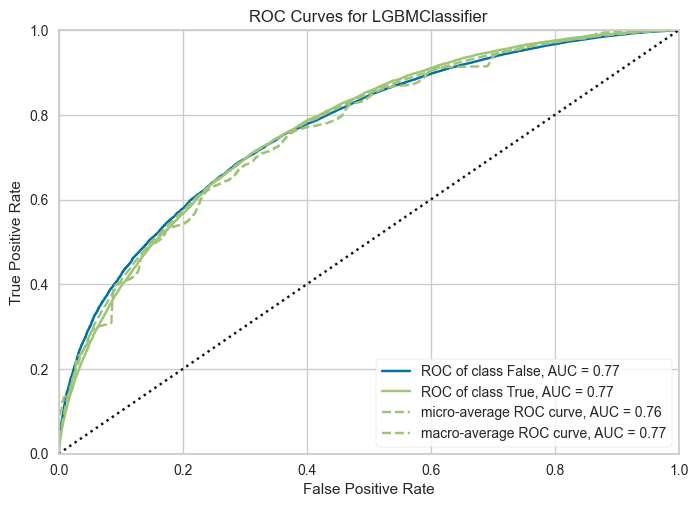

Plotando Gráfico KS...


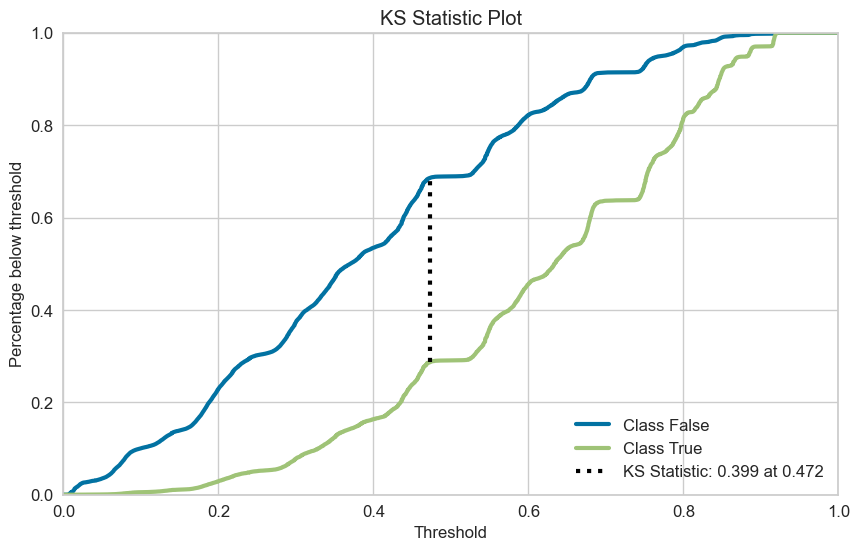

Plotando Importância das Features...


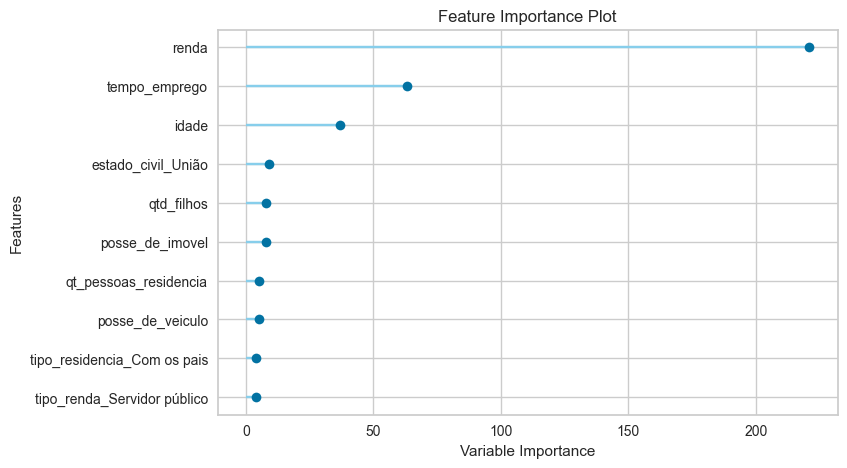

Plotando Matriz de Confusão...


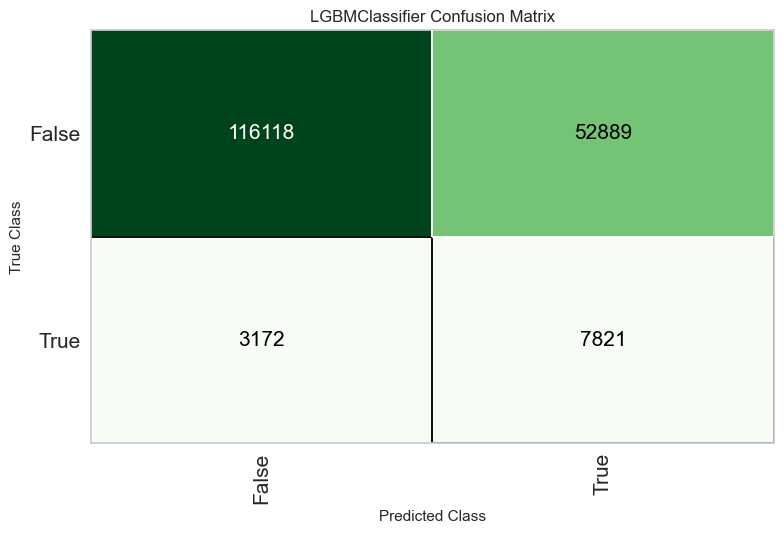


Comandos de plotagem concluídos.


In [19]:
# --- 5. Geração dos Gráficos Finais (Plot) ---
print("\n--- 5. Gerando gráficos ---")
# Os gráficos aparecerão na saída desta célula

print("Plotando Curva ROC (AUC)...")
plot_model(tuned_lgbm, plot='auc')

print("Plotando Gráfico KS...")
plot_model(tuned_lgbm, plot='ks')

print("Plotando Importância das Features...")
plot_model(tuned_lgbm, plot='feature')

print("Plotando Matriz de Confusão...")
plot_model(tuned_lgbm, plot='confusion_matrix')

print("\nComandos de plotagem concluídos.")

In [21]:
# --- 6. Finalização do Modelo ---
print("\n--- 6. Finalizando o modelo ---")
# Treina o modelo (com os parâmetros do 'tuned_lgbm') na base DEV inteira
final_lgbm = finalize_model(tuned_lgbm)
print("\nModelo final treinado na base DEV completa:")
print(final_lgbm)


--- 6. Finalizando o modelo ---

Modelo final treinado na base DEV completa:
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='median'))),
                ('categorical_imputer',
                 TransformerW...
                      

In [22]:
# --- 7. Exibição do Pipeline de Transformação ---
print("\n" + "="*50)
print("PIPELINE DE TODA A TRANSFORMAÇÃO (OTIMIZADO)")
print("="*50)
print(final_lgbm)
print("="*50)


PIPELINE DE TODA A TRANSFORMAÇÃO (OTIMIZADO)
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='median'))),
                ('categorical_imputer',
                 TransformerW...
                                boosting_type='gbdt', 

In [23]:
# --- 8. Avaliação no Hold-Out (Out-of-Time) ---
print("\n--- 8. Avaliando o modelo final na base OOT (Out-of-Time) ---")
# O 'df_oot' foi criado lá na Célula 2
df_oot_sem_target = df_oot.drop('mau', axis=1)

# Aplica o pipeline (pré-processamento + predição)
predictions_oot = predict_model(final_lgbm, data=df_oot_sem_target)

# Junta o resultado com o alvo real para calcular métricas
predictions_oot['mau_real'] = df_oot['mau']

print("\nAmostra das predições na base OOT:")
print(predictions_oot[['prediction_label', 'prediction_score', 'mau_real']].head())

# Calculando Gini e KS manualmente na base OOT
try:
    from sklearn.metrics import roc_auc_score, roc_curve
    
    y_true_oot = predictions_oot['mau_real']
    y_proba_oot = predictions_oot['prediction_score']
    
    auc_oot = roc_auc_score(y_true_oot, y_proba_oot)
    gini_oot = 2 * auc_oot - 1
    
    fpr, tpr, thresholds = roc_curve(y_true_oot, y_proba_oot)
    ks_oot = max(tpr - fpr)
    
    print("\n--- Métricas Finais na Base OOT ---")
    print(f"Gini (OOT): {gini_oot:.2%}")
    print(f"KS (OOT):   {ks_oot:.2%}")

except Exception as e:
    print(f"Erro ao calcular métricas OOT: {e}")


--- 8. Avaliando o modelo final na base OOT (Out-of-Time) ---
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Amostra das predições na base OOT:
        prediction_label  prediction_score  mau_real
600000                 1            0.6805      True
600001                 0            0.5437     False
600002                 0            0.6657  

In [24]:
# --- 9. Salvando o Pipeline Completo ---
print("\n--- 9. Salvando o modelo e pipeline final ---")
save_model(final_lgbm, 'meu_pipeline_lgbm_rapido')
print("Modelo salvo como 'meu_pipeline_lgbm_rapido.pkl'")
print("\n--- FIM DO PROCESSO PYCARET ---")


--- 9. Salvando o modelo e pipeline final ---
Transformation Pipeline and Model Successfully Saved
Modelo salvo como 'meu_pipeline_lgbm_rapido.pkl'

--- FIM DO PROCESSO PYCARET ---
